<div class="alert alert-block alert-info">
    <h2 align="center"style="color: black;">Machine Learning-based Algorithmic Trading</h2>
    <h3 align="center"style="color: black;">Data and Walk Forward Backtest Pipelines</h3>
    <h5 align="center"style="color: black;">Alpha Hunters Team</h5>
</div>

# Kaggle services and tools

In [1]:
!pip install feature_engine
!pip install colorlog
!pip install betacal
!pip install venn_abers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for venn_abers: filename=venn_abers-1.4.6-py3-none-any.whl size=15121 sha256=1a5c82b2eb5412b4c6127e2b80dcc2654e3d137bef349bf97ac1b8e8521239a2
  Stored in directory: /root/.cache/pip/wheels/13/d1/70/93b392e06ef586ef82f6b25af60320ae9a494779fe6312b9a9
Successfully built venn_abers


In [2]:
!pip show xgboost

Name: xgboost
Version: 2.1.3
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, nvidia-nccl-cu12, scipy
Required-by: 


In [3]:
model_type = 'CF-XGB' #@param ['XGB', 'CF-XGB', 'XGBF', 'CF-XGBF', 'RF', 'CF-RF', 'LGBM', 'CF-LGBM'] {type: "string"}
MANUAL_EXP = True #@param {type:"boolean"}

In [4]:
print(MANUAL_EXP)

True


# Weights & Biase

Steps:
- Create a W&B account [wandb.ai](https://wandb.ai/)
- Read docs [W&B docs](https://docs.wandb.ai/)
- Install using pip:  `!pip install wandb`
- Get API token [link](https://wandb.ai/authorize)
- Create a secret or an env variable for the token

In [5]:
import wandb
from google.colab import userdata
secret_value = userdata.get('wandb_token')
wandb.login(key=secret_value)

api = wandb.Api()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
!wandb login

wandb: Currently logged in as: amirhosseinfarahani (alpha-hunters). Use `wandb login --relogin` to force relogin


# Read functions from the GitHub repo

- GitHub account and repo
- Generate an access token on your GitHub account [Link](https://github.com/settings/tokens)
- Then make a secret or an environment variable to use it

In [7]:
import sys
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
token = userdata.get("GITHUB_TOKEN")
branch_name = 'main' #@param ['main', 'masoud'] {type: "string"}
!rm -r ./ML-Algotrading-Project
!git clone -b {branch_name} https://{token}@github.com/AmirhsFar/ML-Algotrading-Project.git
!pip install -r ./ML-Algotrading-Project/dataset/requirements.txt
sys.path.append("/content/ML-Algotrading-Project")
print('All done')

rm: cannot remove './ML-Algotrading-Project': No such file or directory
Cloning into 'ML-Algotrading-Project'...
remote: Enumerating objects: 919, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 919 (delta 79), reused 78 (delta 48), pack-reused 801 (from 1)
Receiving objects: 100% (919/919), 6.09 MiB | 9.45 MiB/s, done.
Resolving deltas: 100% (651/651), done.
ERROR: Could not find a version that satisfies the requirement MetaTrader5==5.0.4424 (from versions: none)
ERROR: No matching distribution found for MetaTrader5==5.0.4424
All done


In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from dataset.configs.feature_configs_general import generate_general_config
from dataset.dukascopy_func import (
    crawl_OHLCV_data_dukascopy
)
from dataset.history_data_stage_one_func import (
    history_data_stage_one
)
from dataset.realtime_candle_func import (
    historiy_realtime_candle
)
from dataset.indicator_func import history_indicator_calculator
from dataset.realtime_shift_func import history_cndl_shift
from dataset.create_basic_features_func import (
    history_basic_features,
    history_fe_market_close,
    history_fe_time
)
from dataset.window_agg_features_func import (
    history_fe_WIN_features
)
from dataset.columns_merge_func import history_columns_merge
# from dataset.data_crawlers.metatrader_func import (
#     crawl_OHLCV_data_metatrader,
# )
from main_func import main
# from forex_MLOps.utils.wandb_utils import read_obj
from ETL import read_data_manual, ETL
# from forex_MLOps.model_ensemble import QuantEnsemble
from utils.wandb_utils import (
    fetch_artifacts, read_tracker_objects, download_wandb_artifact
)
########### READ DATA MANUALLY #########
# df_all = read_data_manual()
# !tail -n 120 ./forex_MLOps/ETL.py

In [9]:
import matplotlib.pyplot as plt
import polars as pl
from datetime import datetime

def plot_price_pivots(
    df: pl.DataFrame,
    center_index: int,
    threshold: int,
    time_frame: int,
    leg_type: str
):
    """
    Creates a line chart showing close prices and pivot points within a
    100-candle window centered around the specified index.

    Parameters:
    df: polars.DataFrame - DataFrame containing '_time', 'M5_CLOSE', and
        'fe_leg_pvt_points_th_650_pct' columns
    center_index: int - The index around which to center the visualization

    Returns:
    matplotlib.figure.Figure - The created figure
    """
    # Set thresholds and index ranges for time frames other than 5M
    idx_range = 100
    if time_frame == 15:
        threshold *= 1.75
        idx_range *= 3
    elif time_frame == 60:
        threshold *= 4.5
        idx_range *= 10

    # Calculate window boundaries
    start_index = max(0, center_index - idx_range)
    end_index = min(len(df), center_index + idx_range)

    # Extract window data
    window_df = df.slice(start_index, end_index - start_index)

    # Convert to lists for easier plotting
    times = window_df.get_column('_time').to_list()
    prices = window_df.get_column(f'M{time_frame}_CLOSE').to_list()
    pivots = window_df.get_column(
        f'fe_leg_pvt_points_M{time_frame}_th_{threshold}_pct'
    ).to_list()

    if leg_type == 'bullish':
        high_distances = window_df.get_column(
            f'fe_leg_blsh_high_dist_M{time_frame}_th_{threshold}_pct'
        ).to_list()
    elif leg_type == 'bearish':
        high_distances = window_df.get_column(
            f'fe_leg_brsh_high_dist_M{time_frame}_th_{threshold}_pct'
        ).to_list()
    else:
        raise ValueError("leg_type must be 'bullish' or 'bearish'")

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot price line
    ax.plot(times, prices, color='blue', linewidth=1.5, label='Close Price')

    # Plot high pivots (1)
    high_pivot_times = [
        times[i] for i in range(len(times)) if pivots[i] == 1
    ]
    high_pivot_prices = [
        prices[i] for i in range(len(prices)) if pivots[i] == 1
    ]
    ax.scatter(high_pivot_times, high_pivot_prices, color='green', marker='^',
              s=100, label='High Pivot')

    # Plot low pivots (-1)
    low_pivot_times = [
        times[i] for i in range(len(times)) if pivots[i] == -1
    ]
    low_pivot_prices = [
        prices[i] for i in range(len(prices)) if pivots[i] == -1
    ]
    ax.scatter(low_pivot_times, low_pivot_prices, color='red', marker='v',
              s=100, label='Low Pivot')

    # Highlight points where high distance is < 100%
    close_to_high_times = [
        times[i] for i in range(len(times))
            if high_distances[i] is not None and high_distances[i] < 100
    ]
    close_to_high_prices = [
        prices[i] for i in range(len(prices))
            if high_distances[i] is not None and high_distances[i] < 100
    ]
    ax.scatter(
        close_to_high_times, close_to_high_prices, color='black',
            marker='o', s=50, label='Close to High (<100%)'
    )

    # Customize the plot
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Price Movement and Pivot Points')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

    # Format x-axis
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(
        plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M')
    )

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    return fig

# 0. Data Fetching & Preprocessing

## Dukascopy

In [10]:
config_general = generate_general_config()
failed_dates_dict = await crawl_OHLCV_data_dukascopy(
    feature_config = config_general
)

  [test run][INFO]:- - - - - - - - - - - - - - - - - - - - - - - - - 
INFO:test run:- - - - - - - - - - - - - - - - - - - - - - - - - 
  [test run][INFO]:--> start crawl_OHLCV_data_dukascopy fumc:
INFO:test run:--> start crawl_OHLCV_data_dukascopy fumc:
  [test run][INFO]:--> number of days ALL in time range: 717
INFO:test run:--> number of days ALL in time range: 717
  [test run][INFO]:--> start_date: 2023-01-01 00:00:00 , stop_date: 2024-12-17 00:00:00
INFO:test run:--> start_date: 2023-01-01 00:00:00 , stop_date: 2024-12-17 00:00:00
  [test run][INFO]:==============================
INFO:test run:==============================
  [test run][INFO]:--> EURUSD
INFO:test run:--> EURUSD
  [test run][INFO]:--> faild_date: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/11/17/BID_candles_min_1.bi5
INFO:test run:--> faild_date: https://datafeed.dukascopy.com/datafeed/EURUSD/2024/11/17/BID_candles_min_1.bi5
  [test run][INFO]:--> df.shape: (1031040, 6)
INFO:test run:--> df.shape: (1031040,

In [11]:
import pandas as pd

pd.set_option('display.max_columns', None)
df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/raw_data/dukascopy/EURUSD_dukascopy.parquet"
)
df.iloc[[1000, 1006, 11012]]

,_time,open,high,low,close,tick_volume,data_source,symbol
1000,2023-01-04 11:20:00+00:00,1.06179,1.06188,1.06151,1.06173,671.040009,dukascopy,EURUSD
1006,2023-01-04 11:50:00+00:00,1.06038,1.06079,1.06021,1.06063,665.929993,dukascopy,EURUSD
11012,2023-02-08 05:40:00+00:00,1.07294,1.07295,1.07280,1.07290,207.729996,dukascopy,EURUSD


## Metatrader 5

Do this section in your system and place the `.parquet` file in *dataset\data\raw_data\metatrader*, then reclone the repository and proceed for the furthur steps.

## Creating Stage-One Data

In [12]:
history_data_stage_one(config_general)

  [test run][INFO]:= = = = = = = = = = = = = = = = = = = = = = = = = 
INFO:test run:= = = = = = = = = = = = = = = = = = = = = = = = = 
  [test run][INFO]:--> start history_data_stage_one fumc:
INFO:test run:--> start history_data_stage_one fumc:
  [test run][INFO]:-------------------------
INFO:test run:-------------------------
  [test run][INFO]:--> symbol:EURUSD
INFO:test run:--> symbol:EURUSD
  [test run][INFO]:--> number of nulls before forward fill: 0
INFO:test run:--> number of nulls before forward fill: 0
  [test run][INFO]:--> min time: 2023-01-03 00:00:00, max time: 2024-12-17 01:55:00
INFO:test run:--> min time: 2023-01-03 00:00:00, max time: 2024-12-17 01:55:00
  [test run][INFO]:--> parquet saved. /content/ML-Algotrading-Project/dataset//data/stage_one_data//EURUSD_stage_one.parquet
INFO:test run:--> parquet saved. /content/ML-Algotrading-Project/dataset//data/stage_one_data//EURUSD_stage_one.parquet
  [test run][INFO]:--> history_data_stage_one run successfully.
INFO:test

In [13]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/stage_one_data/EURUSD_stage_one.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 120000]]

,_time,open,high,low,close,tick_volume,data_source,was_ffilled,_date
1,2023-01-03 00:05:00,1.06648,1.06650,1.06646,1.06650,15.320000,dukascopy,False,2023-01-03
5,2023-01-03 00:25:00,1.06652,1.06652,1.06649,1.06652,10.800000,dukascopy,False,2023-01-03
1000,2023-01-06 11:20:00,1.05131,1.05133,1.04965,1.05060,2732.000031,dukascopy,False,2023-01-06
2006,2023-01-11 23:10:00,1.07557,1.07557,1.07542,1.07550,399.619991,dukascopy,False,2023-01-11
11012,2023-02-24 05:40:00,1.06029,1.06030,1.06015,1.06015,494.959991,dukascopy,False,2023-02-24
120000,2024-08-07 16:00:00,1.09215,1.09224,1.09181,1.09197,465.000000,metatrader,False,2024-08-07


## Creating Real-Time Candles

In [14]:
historiy_realtime_candle(config_general)

  [test run][INFO]:- - - - - - - - - - - - - - - - - - - - - - - - - 
INFO:test run:- - - - - - - - - - - - - - - - - - - - - - - - - 
  [test run][INFO]:--> start historiy_realtime_candle fumc:
INFO:test run:--> start historiy_realtime_candle fumc:
  [test run][INFO]:= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
INFO:test run:= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
  [test run][INFO]:symbol: EURUSD
INFO:test run:symbol: EURUSD
  [test run][INFO]:--> EURUSD saved.
INFO:test run:--> EURUSD saved.
  [test run][INFO]:--> historiy_realtime_candle run successfully.
INFO:test run:--> historiy_realtime_candle run successfully.


In [15]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/realtime_candle/EURUSD_realtime_candle.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000]]

,_time,index,M5_OPEN,M5_CLOSE,M5_LOW,M5_HIGH,M5_VOLUME,_date,minutesPassed,isFirst,M15_OPEN,M15_HIGH,M15_LOW,M15_CLOSE,M15_VOLUME,M30_OPEN,M30_HIGH,M30_LOW,M30_CLOSE,M30_VOLUME,M60_OPEN,M60_HIGH,M60_LOW,M60_CLOSE,M60_VOLUME,M120_OPEN,M120_HIGH,M120_LOW,M120_CLOSE,M120_VOLUME,M180_OPEN,M180_HIGH,M180_LOW,M180_CLOSE,M180_VOLUME,M240_OPEN,M240_HIGH,M240_LOW,M240_CLOSE,M240_VOLUME,M360_OPEN,M360_HIGH,M360_LOW,M360_CLOSE,M360_VOLUME,M720_OPEN,M720_HIGH,M720_LOW,M720_CLOSE,M720_VOLUME,M1440_OPEN,M1440_HIGH,M1440_LOW,M1440_CLOSE,M1440_VOLUME,symbol
1,2023-01-03 00:05:00,1,1.06648,1.06650,1.06646,1.06650,15.320000,2023-01-03,5,0,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,EURUSD
5,2023-01-03 00:25:00,5,1.06652,1.06652,1.06649,1.06652,10.800000,2023-01-03,25,0,1.06651,1.06653,1.06648,1.06652,21.140000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,EURUSD
1000,2023-01-06 11:20:00,1000,1.05131,1.05060,1.04965,1.05133,2732.000031,2023-01-06,680,0,1.05152,1.05172,1.04965,1.05060,4264.860046,1.05182,1.05193,1.04965,1.05060,7522.880005,1.05182,1.05193,1.04965,1.05060,7522.880005,1.05126,1.05309,1.04965,1.05060,26169.890114,1.05123,1.05309,1.04965,1.05060,44967.489998,1.05146,1.05309,1.04965,1.05060,57116.690056,1.05319,1.05343,1.04965,1.05060,75136.170013,1.05195,1.05363,1.04965,1.05060,121960.810206,1.05195,1.05363,1.04965,1.05060,121960.810206,EURUSD
2006,2023-01-11 23:10:00,2006,1.07557,1.07550,1.07542,1.07557,399.619991,2023-01-11,1390,0,1.07537,1.07557,1.07518,1.07550,1465.669991,1.07537,1.07557,1.07518,1.07550,1465.669991,1.07537,1.07557,1.07518,1.07550,1465.669991,1.07629,1.07629,1.07518,1.07550,12623.009968,1.07532,1.07635,1.07474,1.07550,27759.310017,1.07465,1.07680,1.07348,1.07550,51180.689945,1.07549,1.07680,1.07348,1.07550,84159.069904,1.07413,1.07762,1.07279,1.07550,236317.869877,1.07322,1.07762,1.07254,1.07550,393149.089945,EURUSD
11012,2023-02-24 05:40:00,11012,1.06029,1.06015,1.06015,1.06030,494.959991,2023-02-24,340,0,1.06040,1.06051,1.06015,1.06015,2116.589996,1.06040,1.06051,1.06015,1.06015,2116.589996,1.05969,1.06051,1.05968,1.06015,6465.960003,1.06010,1.06061,1.05946,1.06015,19075.199947,1.06069,1.06141,1.05932,1.06015,43866.689800,1.06010,1.06061,1.05946,1.06015,19075.199947,1.05934,1.06141,1.05927,1.06015,63519.159812,1.05934,1.06141,1.05927,1.06015,63519.159812,1.05934,1.06141,1.05927,1.06015,63519.159812,EURUSD
20000,2023-04-10 10:40:00,20000,1.09085,1.09088,1.09079,1.09094,510.120010,2023-04-10,640,0,1.09073,1.09094,1.09064,1.09088,1732.450012,1.09073,1.09094,1.09064,1.09088,1732.450012,1.09050,1.09115,1.09042,1.09088,5878.700008,1.09050,1.09115,1.09042,1.09088,5878.700008,1.08994,1.09115,1.08952,1.09088,11251.800003,1.08961,1.09115,1.08908,1.09088,16178.230016,1.08985,1.09115,1.08908,1.09088,23734.340046,1.09029,1.09145,1.08908,1.09088,59396.489959,1.09029,1.09145,1.08908,1.09088,59396.489959,EURUSD


In [16]:
df.head(10)

,_time,index,M5_OPEN,M5_CLOSE,M5_LOW,M5_HIGH,M5_VOLUME,_date,minutesPassed,isFirst,M15_OPEN,M15_HIGH,M15_LOW,M15_CLOSE,M15_VOLUME,M30_OPEN,M30_HIGH,M30_LOW,M30_CLOSE,M30_VOLUME,M60_OPEN,M60_HIGH,M60_LOW,M60_CLOSE,M60_VOLUME,M120_OPEN,M120_HIGH,M120_LOW,M120_CLOSE,M120_VOLUME,M180_OPEN,M180_HIGH,M180_LOW,M180_CLOSE,M180_VOLUME,M240_OPEN,M240_HIGH,M240_LOW,M240_CLOSE,M240_VOLUME,M360_OPEN,M360_HIGH,M360_LOW,M360_CLOSE,M360_VOLUME,M720_OPEN,M720_HIGH,M720_LOW,M720_CLOSE,M720_VOLUME,M1440_OPEN,M1440_HIGH,M1440_LOW,M1440_CLOSE,M1440_VOLUME,symbol
0,2023-01-03 00:00:00,0,1.06646,1.06648,1.06645,1.06649,34.300000,2023-01-03,0,1,1.06646,1.06649,1.06645,1.06648,34.300000,1.06646,1.06649,1.06645,1.06648,34.300000,1.06646,1.06649,1.06645,1.06648,34.300000,1.06646,1.06649,1.06645,1.06648,34.300000,1.06646,1.06649,1.06645,1.06648,34.300000,1.06646,1.06649,1.06645,1.06648,34.300000,1.06646,1.06649,1.06645,1.06648,34.300000,1.06646,1.06649,1.06645,1.06648,34.300000,1.06646,1.06649,1.06645,1.06648,34.300000,EURUSD
1,2023-01-03 00:05:00,1,1.06648,1.06650,1.06646,1.06650,15.320000,2023-01-03,5,0,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,1.06646,1.06650,1.06645,1.06650,49.620001,EURUSD
2,2023-01-03 00:10:00,2,1.06650,1.06651,1.06650,1.06651,6.510000,2023-01-03,10,0,1.06646,1.06651,1.06645,1.06651,56.130001,1.06646,1.06651,1.06645,1.06651,56.130001,1.06646,1.06651,1.06645,1.06651,56.130001,1.06646,1.06651,1.06645,1.06651,56.130001,1.06646,1.06651,1.06645,1.06651,56.130001,1.06646,1.06651,1.06645,1.06651,56.130001,1.06646,1.06651,1.06645,1.06651,56.130001,1.06646,1.06651,1.06645,1.06651,56.130001,1.06646,1.06651,1.06645,1.06651,56.130001,EURUSD
3,2023-01-03 00:15:00,3,1.06651,1.06653,1.06648,1.06653,9.440000,2023-01-03,15,0,1.06651,1.06653,1.06648,1.06653,9.440000,1.06646,1.06653,1.06645,1.06653,65.570001,1.06646,1.06653,1.06645,1.06653,65.570001,1.06646,1.06653,1.06645,1.06653,65.570001,1.06646,1.06653,1.06645,1.06653,65.570001,1.06646,1.06653,1.06645,1.06653,65.570001,1.06646,1.06653,1.06645,1.06653,65.570001,1.06646,1.06653,1.06645,1.06653,65.570001,1.06646,1.06653,1.06645,1.06653,65.570001,EURUSD
4,2023-01-03 00:20:00,4,1.06653,1.06652,1.06652,1.06653,0.900000,2023-01-03,20,0,1.06651,1.06653,1.06648,1.06652,10.340000,1.06646,1.06653,1.06645,1.06652,66.470001,1.06646,1.06653,1.06645,1.06652,66.470001,1.06646,1.06653,1.06645,1.06652,66.470001,1.06646,1.06653,1.06645,1.06652,66.470001,1.06646,1.06653,1.06645,1.06652,66.470001,1.06646,1.06653,1.06645,1.06652,66.470001,1.06646,1.06653,1.06645,1.06652,66.470001,1.06646,1.06653,1.06645,1.06652,66.470001,EURUSD
5,2023-01-03 00:25:00,5,1.06652,1.06652,1.06649,1.06652,10.800000,2023-01-03,25,0,1.06651,1.06653,1.06648,1.06652,21.140000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,1.06646,1.06653,1.06645,1.06652,77.270000,EURUSD
6,2023-01-03 00:30:00,6,1.06652,1.06648,1.06645,1.06652,55.629999,2023-01-03,30,0,1.06652,1.06652,1.06645,1.06648,55.629999,1.06652,1.06652,1.06645,1.06648,55.629999,1.06646,1.06653,1.06645,1.06648,132.899999,1.06646,1.06653,1.06645,1.06648,132.899999,1.06646,1.06653,1.06645,1.06648,132.899999,1.06646,1.06653,1.06645,1.06648,132.899999,1.06646,1.06653,1.06645,1.06648,132.899999,1.06646,1.06653,1.06645,1.06648,132.899999,1.06646,1.06653,1.06645,1.06648,132.899999,EURUSD
7,2023-01-03 00:35:00,7,1.06647,1.06645,1.06645,1.06651,43.060000,2023-01-03,35,0,1.06652,1.06652,1.06645,1.06645,98.689999,1.06652,1.06652,1.06645,1.06645,98.689999,1.06646,1.06653,

## Adding Features

### A) Indicators

In [17]:
history_indicator_calculator(config_general)

  [test run][INFO]:- - - - - - - - - - - - - - - - - - - - - - - - - 
INFO:test run:- - - - - - - - - - - - - - - - - - - - - - - - - 
  [test run][INFO]:--> start history_indicator_calculator fumc:
INFO:test run:--> start history_indicator_calculator fumc:
  [test run][INFO]:* * * * * * * * * * * * * * * * * * * * * * * * * 
INFO:test run:* * * * * * * * * * * * * * * * * * * * * * * * * 
  [test run][INFO]:--------------------------------------------------
INFO:test run:--------------------------------------------------
  [test run][INFO]:--> symbol:EURUSD | fe_prefix:fe_RSI
INFO:test run:--> symbol:EURUSD | fe_prefix:fe_RSI
  [test run][INFO]:--> max_candle_timeframe:240 | max_window_size:30| drop_rows:1487.0
INFO:test run:--> max_candle_timeframe:240 | max_window_size:30| drop_rows:1487.0
  [test run][INFO]:--> fe_RSI_EURUSD done.
INFO:test run:--> fe_RSI_EURUSD done.
  [test run][INFO]:--------------------------------------------------
INFO:test run:-------------------------------

**Leg**

In [18]:
import polars as pl

pl.Config.set_tbl_rows(200)
df = pl.read_parquet(
    "/content/ML-Algotrading-Project/dataset/data/features/fe_leg/fe_leg_EURUSD.parquet"
)

In [19]:
df[:200]

_time,fe_leg_blsh_high_dist_M5_th_1100_pct,fe_leg_blsh_low_dist_M5_th_1100_pct,fe_leg_brsh_high_dist_M5_th_1100_pct,fe_leg_brsh_low_dist_M5_th_1100_pct,fe_leg_blsh_high_dist_M60_th_6300.0_pct,fe_leg_blsh_low_dist_M60_th_6300.0_pct,fe_leg_brsh_high_dist_M60_th_6300.0_pct,fe_leg_brsh_low_dist_M60_th_6300.0_pct,fe_leg_blsh_high_dist_M15_th_2450.0_pct,fe_leg_blsh_low_dist_M15_th_2450.0_pct,fe_leg_brsh_high_dist_M15_th_2450.0_pct,fe_leg_brsh_low_dist_M15_th_2450.0_pct,fe_leg_blsh_high_dist_M60_th_3600.0_pct,fe_leg_blsh_low_dist_M60_th_3600.0_pct,fe_leg_brsh_high_dist_M60_th_3600.0_pct,fe_leg_brsh_low_dist_M60_th_3600.0_pct,fe_leg_blsh_high_dist_M5_th_800_pct,fe_leg_blsh_low_dist_M5_th_800_pct,fe_leg_brsh_high_dist_M5_th_800_pct,fe_leg_brsh_low_dist_M5_th_800_pct,fe_leg_blsh_high_dist_M60_th_4950.0_pct,fe_leg_blsh_low_dist_M60_th_4950.0_pct,fe_leg_brsh_high_dist_M60_th_4950.0_pct,fe_leg_brsh_low_dist_M60_th_4950.0_pct,fe_leg_blsh_high_dist_M5_th_1400_pct,fe_leg_blsh_low_dist_M5_th_1400_pct,fe_leg_brsh_high_dist_M5_th_1400_pct,fe_leg_brsh_low_dist_M5_th_1400_pct,fe_leg_blsh_high_dist_M15_th_1925.0_pct,fe_leg_blsh_low_dist_M15_th_1925.0_pct,fe_leg_brsh_high_dist_M15_th_1925.0_pct,fe_leg_brsh_low_dist_M15_th_1925.0_pct,fe_leg_blsh_high_dist_M15_th_1400.0_pct,fe_leg_blsh_low_dist_M15_th_1400.0_pct,fe_leg_brsh_high_dist_M15_th_1400.0_pct,fe_leg_brsh_low_dist_M15_th_1400.0_pct,symbol
datetime[ns],i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str
2023-01-03 00:55:00,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,"""EURUSD"""
2023-01-03 01:00:00,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,"""EURUSD"""
2023-01-03 01:05:00,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,"""EURUSD"""
2023-01-03 01:10:00,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,"""EURUSD"""
2023-01-03 01:15:00,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,"""EURUSD"""
2023-01-03 01:20:00,150,150,66,33,150,150,150,150,150,150,150,150,150,150,150,150,150,150,66,33,150,150,150,150,150,150,65,34,150,150,150,150,150,150,150,150,"""EURUSD"""
2023-01-03 01:25:00,150,150,56,43,150,150,150,150,150,150,150,150,150,150,150,150,150,150,56,43,150,150,150,150,150,150,55,44,150,150,150,150,150,150,150,150,"""EURUSD"""
2023-01-03 01:30:00,150,150,42,57,150,150,150,150,150,150,150,150,150,150,150,150,150,150,42,57,150,150,150,150,150,150,41,58,150,150,150,150,150,150,150,150,"""EURUSD"""
2023-01-03 01:35:00,150,150,39,60,150,150,150,150,150,150,150,150,150,150,150,150,150,150,39,60,150,150,150,150,150,150,37,62,150,150,150,150,150,150,150,150,"""EURUSD"""


**Important Note:**

To plot legs using `plot_price_pivots` function, you should do the following:

*  Navigate to the *indicator_func.py* file in your branch.
*  Uncomment the lines commented in `cal_leg_base_func` function.
*  Comment the `df.drop()` line in `cal_leg_base_func` function.
*  Uncomment the for loop inside `history_indicator_calculator` function.
*  Commit and push the changes to your branch.

Note that you should undo the following in order to use this feature in the framework.

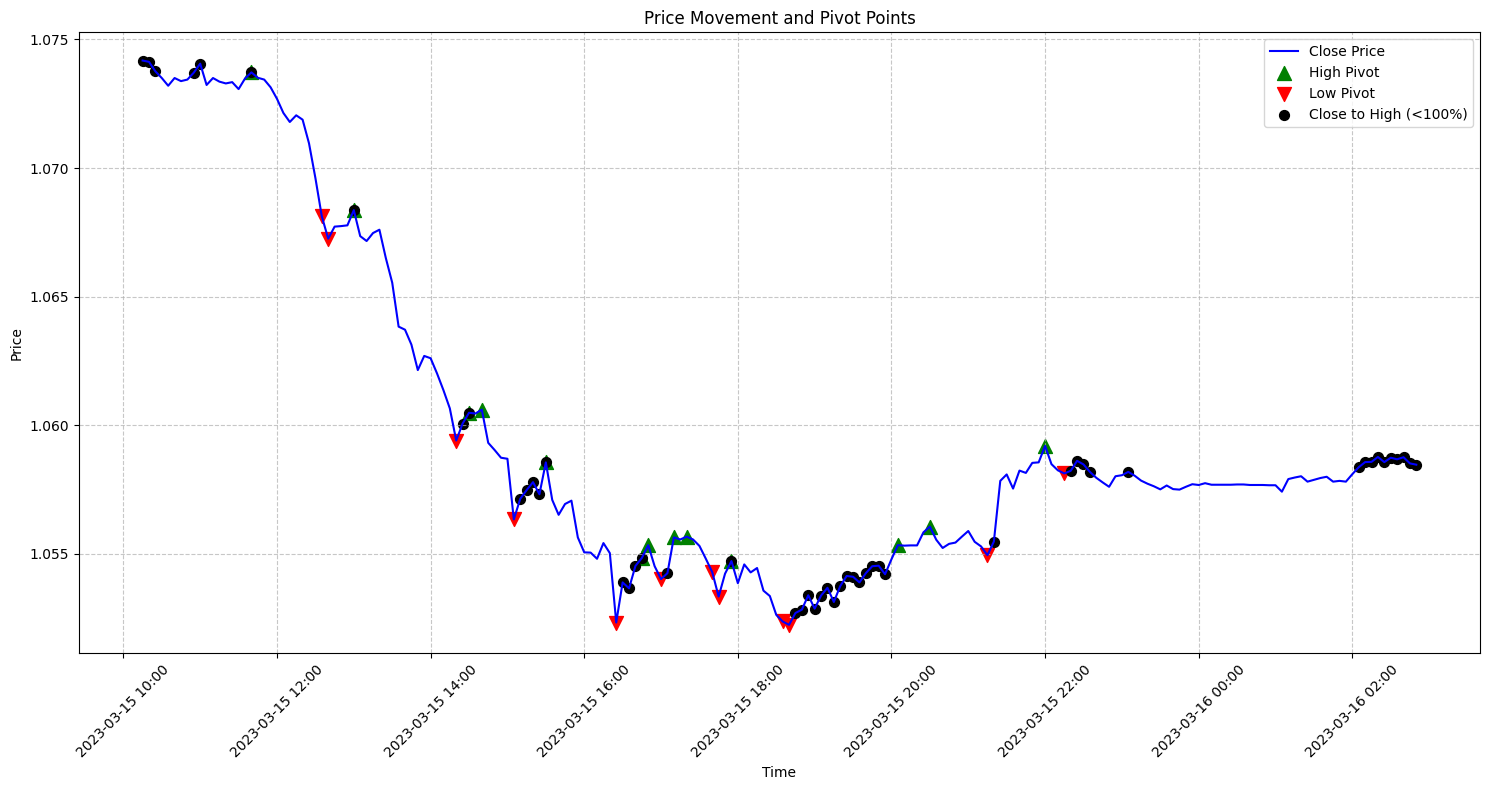

In [ ]:
#@title Plot Legs { run: "auto" }
center_index = 14900  #@param {type: "slider", min:100, max:100000, step:200}
threshold = 1100  #@param [800, 1100, 1400] {type: "raw"}
time_frame = 5  #@param [5, 15, 60] {type: "raw"}
leg_type = 'bearish'  #@param ['bullish', 'bearish'] {type: "string"}

fig = plot_price_pivots(
    df,
    center_index=center_index,
    threshold=threshold,
    time_frame=time_frame,
    leg_type=leg_type
)
plt.show()

**Candle Shape & Context**

In [20]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/features/fe_cndl_shape_n_cntxt/fe_cndl_shape_n_cntxt_EURUSD.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000]]

,_time,fe_cndl_shape_n_cntxt_return_M15_norm,fe_cndl_shape_n_cntxt_up_shadow_M15_norm,fe_cndl_shape_n_cntxt_down_shadow_M15_norm,fe_cndl_shape_n_cntxt_body_length_M15_norm,fe_cndl_shape_n_cntxt_is_bullish_pin_bar_M15,fe_cndl_shape_n_cntxt_is_bearish_pin_bar_M15,fe_cndl_shape_n_cntxt_return_M15_norm_rolling_mean,fe_cndl_shape_n_cntxt_return_M15_norm_rolling_median,fe_cndl_shape_n_cntxt_return_M15_norm_rolling_std,fe_cndl_shape_n_cntxt_return_M15_norm_rolling_range,fe_cndl_shape_n_cntxt_return_M15_norm_rolling_iqr,fe_cndl_shape_n_cntxt_return_M15_norm_ema,fe_cndl_shape_n_cntxt_up_shadow_M15_norm_rolling_mean,fe_cndl_shape_n_cntxt_up_shadow_M15_norm_rolling_median,fe_cndl_shape_n_cntxt_up_shadow_M15_norm_rolling_std,fe_cndl_shape_n_cntxt_up_shadow_M15_norm_rolling_range,fe_cndl_shape_n_cntxt_up_shadow_M15_norm_rolling_iqr,fe_cndl_shape_n_cntxt_up_shadow_M15_norm_ema,fe_cndl_shape_n_cntxt_down_shadow_M15_norm_rolling_mean,fe_cndl_shape_n_cntxt_down_shadow_M15_norm_rolling_median,fe_cndl_shape_n_cntxt_down_shadow_M15_norm_rolling_std,fe_cndl_shape_n_cntxt_down_shadow_M15_norm_rolling_range,fe_cndl_shape_n_cntxt_down_shadow_M15_norm_rolling_iqr,fe_cndl_shape_n_cntxt_down_shadow_M15_norm_ema,fe_cndl_shape_n_cntxt_body_length_M15_norm_rolling_mean,fe_cndl_shape_n_cntxt_body_length_M15_norm_rolling_median,fe_cndl_shape_n_cntxt_body_length_M15_norm_rolling_std,fe_cndl_shape_n_cntxt_body_length_M15_norm_rolling_range,fe_cndl_shape_n_cntxt_body_length_M15_norm_rolling_iqr,fe_cndl_shape_n_cntxt_body_length_M15_norm_ema,fe_cndl_shape_n_cntxt_dist_up_round_1_M15,fe_cndl_shape_n_cntxt_dist_down_round_1_M15,fe_cndl_shape_n_cntxt_dist_up_round_2_M15,fe_cndl_shape_n_cntxt_dist_down_round_2_M15,fe_cndl_shape_n_cntxt_dist_up_round_3_M15,fe_cndl_shape_n_cntxt_dist_down_round_3_M15,fe_cndl_shape_n_cntxt_return_M5_norm,fe_cndl_shape_n_cntxt_up_shadow_M5_norm,fe_cndl_shape_n_cntxt_down_shadow_M5_norm,fe_cndl_shape_n_cntxt_body_length_M5_norm,fe_cndl_shape_n_cntxt_is_bullish_pin_bar_M5,fe_cndl_shape_n_cntxt_is_bearish_pin_bar_M5,fe_cndl_shape_n_cntxt_return_M5_norm_rolling_mean,fe_cndl_shape_n_cntxt_return_M5_norm_rolling_median,fe_cndl_shape_n_cntxt_return_M5_norm_rolling_std,fe_cndl_shape_n_cntxt_return_M5_norm_rolling_range,fe_cndl_shape_n_cntxt_return_M5_norm_rolling_iqr,fe_cndl_shape_n_cntxt_return_M5_norm_ema,fe_cndl_shape_n_cntxt_up_shadow_M5_norm_rolling_mean,fe_cndl_shape_n_cntxt_up_shadow_M5_norm_rolling_median,fe_cndl_shape_n_cntxt_up_shadow_M5_norm_rolling_std,fe_cndl_shape_n_cntxt_up_shadow_M5_norm_rolling_range,fe_cndl_shape_n_cntxt_up_shadow_M5_norm_rolling_iqr,fe_cndl_shape_n_cntxt_up_shadow_M5_norm_ema,fe_cndl_shape_n_cntxt_down_shadow_M5_norm_rolling_mean,fe_cndl_shape_n_cntxt_down_shadow_M5_norm_rolling_median,fe_cndl_shape_n_cntxt_down_shadow_M5_norm_rolling_std,fe_cndl_shape_n_cntxt_down_shadow_M5_norm_rolling_range,fe_cndl_shape_n_cntxt_down_shadow_M5_norm_rolling_iqr,fe_cndl_shape_n_cntxt_down_shadow_M5_norm_ema,fe_cndl_shape_n_cntxt_body_length_M5_norm_rolling_mean,fe_cndl_shape_n_cntxt_body_length_M5_norm_rolling_median,fe_cndl_shape_n_cntxt_body_length_M5_norm_rolling_std,fe_cndl_shape_n_cntxt_body_length_M5_norm_rolling_range,fe_cndl_shape_n_cntxt_body_length_M5_norm_rolling_iqr,fe_cndl_shape_n_cntxt_body_length_M5_norm_ema,fe_cndl_shape_n_cntxt_dist_up_round_1_M5,fe_cndl_shape_n_cntxt_dist_down_round_1_M5,fe_cndl_shape_n_cntxt_dist_up_round_2_M5,fe_cndl_shape_n_cntxt_dist_down_round_2_M5,fe_cndl_shape_n_cntxt_dist_up_round_3_M5,fe_cndl_shape_n_cntxt_dist_down_round_3_M5,fe_cndl_shape_n_cntxt_return_M60_norm,fe_cndl_shape_n_cntxt_up_shadow_M60_norm,fe_cndl_shape_n_cntxt_down_shadow_M60_norm,fe_cndl_shape_n_cntxt_body_length_M60_norm,fe_cndl_shape_n_cntxt_is_bullish_pin_bar_M60,fe_cndl_shape_n_cntxt_is_bearish_pin_bar_M60,fe_cndl_shape_n_cntxt_return_M60_norm_rolling_mean,fe_cndl_shape_n_cntxt_return_M60_norm_rolling_median,fe_cndl_shape_n_cntxt_return_M60_norm_rolling_std,fe_cndl_shape_n_cntxt_return_M60_norm_rolling_range,fe

In [21]:
df.head(20)

,_time,fe_cndl_shape_n_cntxt_return_M15_norm,fe_cndl_shape_n_cntxt_up_shadow_M15_norm,fe_cndl_shape_n_cntxt_down_shadow_M15_norm,fe_cndl_shape_n_cntxt_body_length_M15_norm,fe_cndl_shape_n_cntxt_is_bullish_pin_bar_M15,fe_cndl_shape_n_cntxt_is_bearish_pin_bar_M15,fe_cndl_shape_n_cntxt_return_M15_norm_rolling_mean,fe_cndl_shape_n_cntxt_return_M15_norm_rolling_median,fe_cndl_shape_n_cntxt_return_M15_norm_rolling_std,fe_cndl_shape_n_cntxt_return_M15_norm_rolling_range,fe_cndl_shape_n_cntxt_return_M15_norm_rolling_iqr,fe_cndl_shape_n_cntxt_return_M15_norm_ema,fe_cndl_shape_n_cntxt_up_shadow_M15_norm_rolling_mean,fe_cndl_shape_n_cntxt_up_shadow_M15_norm_rolling_median,fe_cndl_shape_n_cntxt_up_shadow_M15_norm_rolling_std,fe_cndl_shape_n_cntxt_up_shadow_M15_norm_rolling_range,fe_cndl_shape_n_cntxt_up_shadow_M15_norm_rolling_iqr,fe_cndl_shape_n_cntxt_up_shadow_M15_norm_ema,fe_cndl_shape_n_cntxt_down_shadow_M15_norm_rolling_mean,fe_cndl_shape_n_cntxt_down_shadow_M15_norm_rolling_median,fe_cndl_shape_n_cntxt_down_shadow_M15_norm_rolling_std,fe_cndl_shape_n_cntxt_down_shadow_M15_norm_rolling_range,fe_cndl_shape_n_cntxt_down_shadow_M15_norm_rolling_iqr,fe_cndl_shape_n_cntxt_down_shadow_M15_norm_ema,fe_cndl_shape_n_cntxt_body_length_M15_norm_rolling_mean,fe_cndl_shape_n_cntxt_body_length_M15_norm_rolling_median,fe_cndl_shape_n_cntxt_body_length_M15_norm_rolling_std,fe_cndl_shape_n_cntxt_body_length_M15_norm_rolling_range,fe_cndl_shape_n_cntxt_body_length_M15_norm_rolling_iqr,fe_cndl_shape_n_cntxt_body_length_M15_norm_ema,fe_cndl_shape_n_cntxt_dist_up_round_1_M15,fe_cndl_shape_n_cntxt_dist_down_round_1_M15,fe_cndl_shape_n_cntxt_dist_up_round_2_M15,fe_cndl_shape_n_cntxt_dist_down_round_2_M15,fe_cndl_shape_n_cntxt_dist_up_round_3_M15,fe_cndl_shape_n_cntxt_dist_down_round_3_M15,fe_cndl_shape_n_cntxt_return_M5_norm,fe_cndl_shape_n_cntxt_up_shadow_M5_norm,fe_cndl_shape_n_cntxt_down_shadow_M5_norm,fe_cndl_shape_n_cntxt_body_length_M5_norm,fe_cndl_shape_n_cntxt_is_bullish_pin_bar_M5,fe_cndl_shape_n_cntxt_is_bearish_pin_bar_M5,fe_cndl_shape_n_cntxt_return_M5_norm_rolling_mean,fe_cndl_shape_n_cntxt_return_M5_norm_rolling_median,fe_cndl_shape_n_cntxt_return_M5_norm_rolling_std,fe_cndl_shape_n_cntxt_return_M5_norm_rolling_range,fe_cndl_shape_n_cntxt_return_M5_norm_rolling_iqr,fe_cndl_shape_n_cntxt_return_M5_norm_ema,fe_cndl_shape_n_cntxt_up_shadow_M5_norm_rolling_mean,fe_cndl_shape_n_cntxt_up_shadow_M5_norm_rolling_median,fe_cndl_shape_n_cntxt_up_shadow_M5_norm_rolling_std,fe_cndl_shape_n_cntxt_up_shadow_M5_norm_rolling_range,fe_cndl_shape_n_cntxt_up_shadow_M5_norm_rolling_iqr,fe_cndl_shape_n_cntxt_up_shadow_M5_norm_ema,fe_cndl_shape_n_cntxt_down_shadow_M5_norm_rolling_mean,fe_cndl_shape_n_cntxt_down_shadow_M5_norm_rolling_median,fe_cndl_shape_n_cntxt_down_shadow_M5_norm_rolling_std,fe_cndl_shape_n_cntxt_down_shadow_M5_norm_rolling_range,fe_cndl_shape_n_cntxt_down_shadow_M5_norm_rolling_iqr,fe_cndl_shape_n_cntxt_down_shadow_M5_norm_ema,fe_cndl_shape_n_cntxt_body_length_M5_norm_rolling_mean,fe_cndl_shape_n_cntxt_body_length_M5_norm_rolling_median,fe_cndl_shape_n_cntxt_body_length_M5_norm_rolling_std,fe_cndl_shape_n_cntxt_body_length_M5_norm_rolling_range,fe_cndl_shape_n_cntxt_body_length_M5_norm_rolling_iqr,fe_cndl_shape_n_cntxt_body_length_M5_norm_ema,fe_cndl_shape_n_cntxt_dist_up_round_1_M5,fe_cndl_shape_n_cntxt_dist_down_round_1_M5,fe_cndl_shape_n_cntxt_dist_up_round_2_M5,fe_cndl_shape_n_cntxt_dist_down_round_2_M5,fe_cndl_shape_n_cntxt_dist_up_round_3_M5,fe_cndl_shape_n_cntxt_dist_down_round_3_M5,fe_cndl_shape_n_cntxt_return_M60_norm,fe_cndl_shape_n_cntxt_up_shadow_M60_norm,fe_cndl_shape_n_cntxt_down_shadow_M60_norm,fe_cndl_shape_n_cntxt_body_length_M60_norm,fe_cndl_shape_n_cntxt_is_bullish_pin_bar_M60,fe_cndl_shape_n_cntxt_is_bearish_pin_bar_M60,fe_cndl_shape_n_cntxt_return_M60_norm_rolling_mean,fe_cndl_shape_n_cntxt_return_M60_norm_rolling_median,fe_cndl_shape_n_cntxt_return_M60_norm_rolling_std,fe_cndl_shape_n_cntxt_return_M60_norm_rolling_range,fe

**ATR**

In [22]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/features/fe_ATR/fe_ATR_EURUSD.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000]]

,_time,fe_ATR_W14_M240,fe_ATR_W30_M60,fe_ATR_W7_M60,fe_ATR_W7_M240,fe_ATR_W30_M240,fe_ATR_W14_M60,symbol
1,2023-01-10 04:00:00,40.957143,16.616667,12.600000,36.228571,43.633333,18.071429,EURUSD
5,2023-01-10 04:20:00,40.957143,16.616667,12.600000,36.228571,43.633333,18.071429,EURUSD
1000,2023-01-13 15:15:00,38.900000,22.896667,21.600000,48.885714,39.236667,17.428571,EURUSD
2006,2023-01-19 03:05:00,41.635714,19.860000,8.928571,47.628571,42.166667,22.407143,EURUSD
11012,2023-03-03 09:35:00,31.221429,13.646667,9.500000,27.985714,30.186667,10.450000,EURUSD
20000,2023-04-17 14:35:00,31.078571,14.980000,15.057143,35.128571,29.563333,12.542857,EURUSD


**RSTD**

In [23]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/features/fe_RSTD/fe_RSTD_EURUSD.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000]]

,_time,fe_RSTD_M240_CLOSE_W30_cndl_M240,fe_RSTD_M240_CLOSE_W7_cndl_M240,fe_RSTD_M240_CLOSE_W14_cndl_M240,symbol
1,2023-01-10 04:00:00,33.800598,22.196076,28.851866,EURUSD
5,2023-01-10 04:20:00,33.800598,22.196076,28.851866,EURUSD
1000,2023-01-13 15:15:00,22.990681,23.693676,17.349237,EURUSD
2006,2023-01-19 03:05:00,29.125541,42.221738,33.624757,EURUSD
11012,2023-03-03 09:35:00,19.887670,17.424743,20.490879,EURUSD
20000,2023-04-17 14:35:00,21.233008,22.011785,21.546791,EURUSD


**ratio**

In [24]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/features/fe_ratio/fe_ratio_EURUSD.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000]]

,_time,fe_ratio_RSI_M5_CLOSE_W7_W14_cndl_M5,fe_ratio_RSI_M5_CLOSE_W7_W30_cndl_M5,fe_ratio_RSI_M60_CLOSE_W7_W14_cndl_M60,fe_ratio_RSI_M60_CLOSE_W7_W30_cndl_M60,fe_ratio_RSI_M240_CLOSE_W7_W14_cndl_M240,fe_ratio_RSI_M240_CLOSE_W7_W30_cndl_M240,fe_ratio_EMA_M5_CLOSE_W7_W60_cndl_M5,fe_ratio_EMA_M5_CLOSE_W60_W336_cndl_M5,fe_ratio_EMA_M5_CLOSE_W60_W1440_cndl_M5,fe_ratio_SMA_M5_CLOSE_W240_W720_cndl_M5,fe_ratio_SMA_M5_CLOSE_W360_W720_cndl_M5,fe_ratio_ATR_M60_CLOSE_W7_W14_cndl_M60,fe_ratio_ATR_M60_CLOSE_W7_W30_cndl_M60,fe_ratio_ATR_M240_CLOSE_W7_W14_cndl_M240,fe_ratio_ATR_M240_CLOSE_W7_W30_cndl_M240,fe_ratio_RSTD_M240_CLOSE_W7_W14_cndl_M240,fe_ratio_RSTD_M240_CLOSE_W7_W30_cndl_M240,symbol
1,2023-01-10 04:00:00,1.10364,1.24858,0.92447,0.93830,1.09920,1.21066,0.18333,0.08811,0.03184,0.16447,0.32427,0.69723,0.75827,0.88455,0.83030,0.76931,0.65668,EURUSD
5,2023-01-10 04:20:00,1.07202,1.22618,0.92447,0.93830,1.09920,1.21066,0.21334,0.15171,0.05710,0.18357,0.33907,0.69723,0.75827,0.88455,0.83030,0.76931,0.65668,EURUSD
1000,2023-01-13 15:15:00,1.21804,1.29301,0.66147,0.56106,1.01861,1.10077,-0.09465,1.26029,-0.22112,-1.22493,-0.36034,1.23934,0.94337,1.25670,1.24592,1.36569,1.03058,EURUSD
2006,2023-01-19 03:05:00,1.07378,1.13642,0.85202,0.78994,0.90326,0.82459,-9.42515,0.02088,0.05142,1.12334,0.62363,0.39847,0.44958,1.14394,1.12953,1.25567,1.44965,EURUSD
11012,2023-03-03 09:35:00,0.92585,0.89426,1.24219,1.32987,0.97893,1.00778,-0.04950,1.20735,3.04681,-2.85007,-0.56173,0.90909,0.69614,0.89636,0.92709,0.85037,0.87616,EURUSD
20000,2023-04-17 14:35:00,0.71864,0.64987,1.09720,1.02517,0.77015,0.68171,0.36801,0.25329,1.39218,0.22549,0.69338,1.20046,1.00515,1.13031,1.18825,1.02158,1.03668,EURUSD


**SMA**

In [25]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/features/fe_SMA/fe_SMA_EURUSD.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000]]

,_time,fe_SMA_M5_CLOSE_W240_cndl_M5_norm,fe_SMA_M5_CLOSE_W360_cndl_M5_norm,fe_SMA_M5_CLOSE_W720_cndl_M5_norm,symbol
1,2023-01-05 12:05:00,-7.779167,-11.809722,-19.095972,EURUSD
5,2023-01-05 12:25:00,-7.900417,-11.435833,-19.553472,EURUSD
1000,2023-01-10 23:20:00,-2.746667,-1.176389,-51.889861,EURUSD
2006,2023-01-16 11:10:00,25.888333,26.924722,7.948056,EURUSD
11012,2023-02-28 17:40:00,-19.715417,-27.663056,-45.524028,EURUSD
20000,2023-04-12 22:40:00,-42.127917,-54.114167,-81.302361,EURUSD


**RSI**

In [26]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/features/fe_RSI/fe_RSI_EURUSD.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000]]

,_time,fe_RSI_M240_CLOSE_W7_cndl_M240,fe_RSI_M240_CLOSE_W7_gte_70_cndl_M240,fe_RSI_M240_CLOSE_W7_lte_30_cndl_M240,fe_RSI_M5_CLOSE_W30_cndl_M5,fe_RSI_M5_CLOSE_W30_gte_70_cndl_M5,fe_RSI_M5_CLOSE_W30_lte_30_cndl_M5,fe_RSI_M5_CLOSE_W14_cndl_M5,fe_RSI_M5_CLOSE_W14_gte_70_cndl_M5,fe_RSI_M5_CLOSE_W14_lte_30_cndl_M5,fe_RSI_M60_CLOSE_W7_cndl_M60,fe_RSI_M60_CLOSE_W7_gte_70_cndl_M60,fe_RSI_M60_CLOSE_W7_lte_30_cndl_M60,fe_RSI_M60_CLOSE_W30_cndl_M60,fe_RSI_M60_CLOSE_W30_gte_70_cndl_M60,fe_RSI_M60_CLOSE_W30_lte_30_cndl_M60,fe_RSI_M60_CLOSE_W14_cndl_M60,fe_RSI_M60_CLOSE_W14_gte_70_cndl_M60,fe_RSI_M60_CLOSE_W14_lte_30_cndl_M60,fe_RSI_M5_CLOSE_W7_cndl_M5,fe_RSI_M5_CLOSE_W7_gte_70_cndl_M5,fe_RSI_M5_CLOSE_W7_lte_30_cndl_M5,fe_RSI_M240_CLOSE_W14_cndl_M240,fe_RSI_M240_CLOSE_W14_gte_70_cndl_M240,fe_RSI_M240_CLOSE_W14_lte_30_cndl_M240,fe_RSI_M240_CLOSE_W30_cndl_M240,fe_RSI_M240_CLOSE_W30_gte_70_cndl_M240,fe_RSI_M240_CLOSE_W30_lte_30_cndl_M240,symbol
1,2023-01-10 04:00:00,75.481220,True,False,53.667595,False,False,60.715630,False,False,59.413433,False,False,63.320560,False,False,64.267715,False,False,67.008366,False,False,68.669294,False,False,62.347311,False,False,EURUSD
5,2023-01-10 04:20:00,75.481220,True,False,56.658967,False,False,64.806664,False,False,59.413433,False,False,63.320560,False,False,64.267715,False,False,69.474144,False,False,68.669294,False,False,62.347311,False,False,EURUSD
1000,2023-01-13 15:15:00,74.815001,True,False,41.394286,False,False,43.942078,False,False,29.692562,False,True,52.922225,False,False,44.888632,False,False,53.523362,False,False,73.448419,True,False,67.966007,False,False,EURUSD
2006,2023-01-19 03:05:00,43.463978,False,False,49.807106,False,False,52.712556,False,False,36.619519,False,False,46.357422,False,False,42.979763,False,False,56.601702,False,False,48.118779,False,False,52.709877,False,False,EURUSD
11012,2023-03-03 09:35:00,48.155659,False,False,56.943621,False,False,55.000955,False,False,68.119519,False,False,51.222783,False,False,54.838257,False,False,50.922419,False,False,49.192361,False,False,47.784069,False,False,EURUSD
20000,2023-04-17 14:35:00,35.754040,False,False,44.974307,False,False,40.670144,False,False,47.109967,False,False,45.953516,False,False,42.936395,False,False,29.227274,False,True,46.425033,False,False,52.447879,False,False,EURUSD


**EMA**

In [27]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/features/fe_EMA/fe_EMA_EURUSD.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000]]

,_time,fe_EMA_M5_CLOSE_W1440_cndl_M5_norm,fe_EMA_M5_CLOSE_W7_cndl_M5_norm,fe_EMA_M5_CLOSE_W336_cndl_M5_norm,fe_EMA_M5_CLOSE_W60_cndl_M5_norm,symbol
1,2023-01-10 00:05:00,-107.465487,1.143644,-42.736681,7.880523,EURUSD
5,2023-01-10 00:25:00,-107.675895,-0.256894,-42.623860,6.035760,EURUSD
1000,2023-01-13 11:20:00,-96.001273,8.072713,-21.160687,3.594805,EURUSD
2006,2023-01-18 23:10:00,11.177333,1.148326,24.182541,10.916314,EURUSD
11012,2023-03-03 05:40:00,10.969361,-0.150666,8.033484,-0.855511,EURUSD
20000,2023-04-17 10:40:00,-13.377422,2.481712,10.546297,-4.449499,EURUSD


### B) Shift Features

In [28]:
history_cndl_shift(config_general)

  [test run][INFO]:= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
INFO:test run:= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
  [test run][INFO]:--> start history_cndl_shift fumc:
INFO:test run:--> start history_cndl_shift fumc:
  [test run][INFO]:-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  
INFO:test run:-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  
  [test run][INFO]:--> fe_cndl_shift | EURUSD saved.
INFO:test run:--> fe_cndl_shift | EURUSD saved.
  [test run][INFO]:--> history_cndl_shift run successfully.
INFO:test run:--> history_cndl_shift run successfully.


In [29]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/features/fe_cndl_shift_raw/fe_cndl_shift_EURUSD.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000, 35000, 70000, 120000]]

,_time,M5_OPEN_-1,M5_HIGH_-1,M5_LOW_-1,M5_CLOSE_-1,M15_OPEN_-1,M15_HIGH_-1,M15_LOW_-1,M15_CLOSE_-1,M30_OPEN_-1,M30_HIGH_-1,M30_LOW_-1,M30_CLOSE_-1,M60_OPEN_-1,M60_HIGH_-1,M60_LOW_-1,M60_CLOSE_-1,M240_OPEN_-1,M240_HIGH_-1,M240_LOW_-1,M240_CLOSE_-1,M1440_OPEN_-1,M1440_HIGH_-1,M1440_LOW_-1,M1440_CLOSE_-1
1,2023-01-03 00:05:00,1.06646,1.06649,1.06645,1.06648,1.06646,1.06649,1.06645,1.06648,1.06646,1.06649,1.06645,1.06648,1.06646,1.06649,1.06645,1.06648,1.06646,1.06649,1.06645,1.06648,1.06646,1.06649,1.06645,1.06648
5,2023-01-03 00:25:00,1.06653,1.06653,1.06652,1.06652,1.06646,1.06651,1.06645,1.06651,1.06646,1.06649,1.06645,1.06648,1.06646,1.06649,1.06645,1.06648,1.06646,1.06649,1.06645,1.06648,1.06646,1.06649,1.06645,1.06648
1000,2023-01-06 11:20:00,1.05152,1.05172,1.05124,1.05130,1.05182,1.05193,1.05145,1.05150,1.05187,1.05264,1.05155,1.05183,1.05126,1.05309,1.05109,1.05183,1.05250,1.05363,1.05105,1.05142,1.06006,1.06314,1.05148,1.05202
2006,2023-01-11 23:10:00,1.07549,1.07556,1.07535,1.07556,1.07576,1.07589,1.07523,1.07537,1.07575,1.07589,1.07523,1.07537,1.07629,1.07629,1.07523,1.07537,1.07498,1.07762,1.07362,1.07465,1.07293,1.07592,1.07119,1.07322
11012,2023-02-24 05:40:00,1.06041,1.06046,1.06022,1.06028,1.06040,1.06050,1.06025,1.06038,1.05969,1.06050,1.05968,1.06038,1.06010,1.06061,1.05946,1.05969,1.05934,1.06141,1.05927,1.06010,1.06031,1.06275,1.05769,1.05949
20000,2023-04-10 10:40:00,1.09067,1.09088,1.09067,1.09085,1.09084,1.09115,1.09070,1.09071,1.09050,1.09115,1.09042,1.09071,1.08994,1.09054,1.08952,1.09048,1.09034,1.09066,1.08951,1.08962,1.09196,1.09240,1.08762,1.09029
35000,2023-06-21 12:40:00,1.09269,1.09278,1.09230,1.09247,1.09184,1.09277,1.09182,1.09277,1.09249,1.09277,1.09167,1.09277,1.09127,1.09336,1.09093,1.09248,1.09161,1.09336,1.09058,1.09248,1.09201,1.09461,1.08921,1.09173
70000,2023-12-08 01:20:00,1.07920,1.07921,1.07908,1.07908,1.07922,1.07965,1.07918,1.07919,1.07921,1.07953,1.07915,1.07921,1.07927,1.07969,1.07888,1.07921,1.08132,1.08133,1.07902,1.07929,1.07635,1.08171,1.07548,1.07929
120000,2024-08-07 16:00:00,1.09188,1.09220,1.09188,1.09215,1.09158,1.09220,1.09156,1.09215,1.09141,1.09220,1.09131,1.09215,1.09229,1.09253,1.09131,1.09215,1.09184,1.09262,1.09081,1.09215,1.09512,1.09627,1.09034,1.09296


### C) Candle & Time Features

In [30]:
history_basic_features(config_general)
history_fe_market_close(config_general)
history_fe_time(config_general)

  [test run][INFO]:- - - - - - - - - - - - - - - - - - - - - - - - - 
INFO:test run:- - - - - - - - - - - - - - - - - - - - - - - - - 
  [test run][INFO]:--> start history_basic_features fumc:
INFO:test run:--> start history_basic_features fumc:
  [test run][INFO]:- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
INFO:test run:- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
  [test run][INFO]:--> fe_cndl, EURUSD:
INFO:test run:--> fe_cndl, EURUSD:
  [test run][INFO]:--> fe_cndl EURUSD saved.
INFO:test run:--> fe_cndl EURUSD saved.
  [test run][INFO]:- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
INFO:test run:- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
  [test run][INFO]:--> fe_cndl_shift, EURUSD :
INFO:test run:--> fe_cndl_shift, EURUSD :
  [test run][INFO]:--> fe_cndl_shift_stage_2 EURUSD saved.
INFO:test run:--> fe_cndl_shift_stage_2 EURUSD saved.
  [test run][INFO]:--> history_basic_features run successfully.
INFO:test run:--> 

**Candle Shift**

In [31]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/features/fe_cndl_shift/fe_cndl_shift_EURUSD.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000, 35000, 70000, 120000]]

,_time,fe_cndl_shift_M5_CLOSE_to_OPEN_-1,fe_cndl_shift_M5_HIGH_to_LOW_-1,fe_cndl_shift_M5_HIGH_to_CLOSE_-1,fe_cndl_shift_M5_HIGH_to_OPEN_-1,fe_cndl_shift_M5_OPEN_to_LOW_-1,fe_cndl_shift_M5_CLOSE_to_LOW_-1,fe_cndl_shift_M15_CLOSE_to_OPEN_-1,fe_cndl_shift_M15_HIGH_to_LOW_-1,fe_cndl_shift_M15_HIGH_to_CLOSE_-1,fe_cndl_shift_M15_HIGH_to_OPEN_-1,fe_cndl_shift_M15_OPEN_to_LOW_-1,fe_cndl_shift_M15_CLOSE_to_LOW_-1,fe_cndl_shift_M30_CLOSE_to_OPEN_-1,fe_cndl_shift_M30_HIGH_to_LOW_-1,fe_cndl_shift_M30_HIGH_to_CLOSE_-1,fe_cndl_shift_M30_HIGH_to_OPEN_-1,fe_cndl_shift_M30_OPEN_to_LOW_-1,fe_cndl_shift_M30_CLOSE_to_LOW_-1,fe_cndl_shift_M60_CLOSE_to_OPEN_-1,fe_cndl_shift_M60_HIGH_to_LOW_-1,fe_cndl_shift_M60_HIGH_to_CLOSE_-1,fe_cndl_shift_M60_HIGH_to_OPEN_-1,fe_cndl_shift_M60_OPEN_to_LOW_-1,fe_cndl_shift_M60_CLOSE_to_LOW_-1,fe_cndl_shift_M240_CLOSE_to_OPEN_-1,fe_cndl_shift_M240_HIGH_to_LOW_-1,fe_cndl_shift_M240_HIGH_to_CLOSE_-1,fe_cndl_shift_M240_HIGH_to_OPEN_-1,fe_cndl_shift_M240_OPEN_to_LOW_-1,fe_cndl_shift_M240_CLOSE_to_LOW_-1,fe_cndl_shift_M1440_CLOSE_to_OPEN_-1,fe_cndl_shift_M1440_HIGH_to_LOW_-1,fe_cndl_shift_M1440_HIGH_to_CLOSE_-1,fe_cndl_shift_M1440_HIGH_to_OPEN_-1,fe_cndl_shift_M1440_OPEN_to_LOW_-1,fe_cndl_shift_M1440_CLOSE_to_LOW_-1,symbol
1,2023-01-03 00:05:00,0.00002,0.00004,0.00001,0.00003,0.00001,0.00003,0.00002,0.00004,0.00001,0.00003,0.00001,0.00003,0.00002,0.00004,0.00001,0.00003,0.00001,0.00003,0.00002,0.00004,0.00001,0.00003,0.00001,0.00003,0.00002,0.00004,0.00001,0.00003,0.00001,0.00003,0.00002,0.00004,0.00001,0.00003,0.00001,0.00003,EURUSD
5,2023-01-03 00:25:00,-0.00001,0.00001,0.00001,0.00000,0.00001,0.00000,0.00005,0.00006,0.00000,0.00005,0.00001,0.00006,0.00002,0.00004,0.00001,0.00003,0.00001,0.00003,0.00002,0.00004,0.00001,0.00003,0.00001,0.00003,0.00002,0.00004,0.00001,0.00003,0.00001,0.00003,0.00002,0.00004,0.00001,0.00003,0.00001,0.00003,EURUSD
1000,2023-01-06 11:20:00,-0.00022,0.00048,0.00042,0.00020,0.00028,0.00006,-0.00032,0.00048,0.00043,0.00011,0.00037,0.00005,-0.00004,0.00109,0.00081,0.00077,0.00032,0.00028,0.00057,0.00200,0.00126,0.00183,0.00017,0.00074,-0.00108,0.00258,0.00221,0.00113,0.00145,0.00037,-0.00804,0.01166,0.01112,0.00308,0.00858,0.00054,EURUSD
2006,2023-01-11 23:10:00,0.00007,0.00021,0.00000,0.00007,0.00014,0.00021,-0.00039,0.00066,0.00052,0.00013,0.00053,0.00014,-0.00038,0.00066,0.00052,0.00014,0.00052,0.00014,-0.00092,0.00106,0.00092,0.00000,0.00106,0.00014,-0.00033,0.00400,0.00297,0.00264,0.00136,0.00103,0.00029,0.00473,0.00270,0.00299,0.00174,0.00203,EURUSD
11012,2023-02-24 05:40:00,-0.00013,0.00024,0.00018,0.00005,0.00019,0.00006,-0.00002,0.00025,0.00012,0.00010,0.00015,0.00013,0.00069,0.00082,0.00012,0.00081,0.00001,0.00070,-0.00041,0.00115,0.00092,0.00051,0.00064,0.00023,0.00076,0.00214,0.00131,0.00207,0.00007,0.00083,-0.00082,0.00506,0.00326,0.00244,0.00262,0.00180,EURUSD
20000,2023-04-10 10:40:00,0.00018,0.00021,0.00003,0.00021,0.00000,0.00018,-0.00013,0.00045,0.00044,0.00031,0.00014,0.00001,0.00021,0.00073,0.00044,0.00065,0.00008,0.00029,0.00054,0.00102,0.00006,0.00060,0.00042,0.00096,-0.00072,0.00115,0.00104,0.00032,0.00083,0.00011,-0.00167,0.00478,0.00211,0.00044,0.00434,0.00267,EURUSD
35000,2023-06-21 12:40:00,-0.00022,0.00048,0.00031,0.00009,0.00039,0.00017,0.00093,0.00095,0.00000,0.00093,0.00002,0.00095,0.00028,0.00110,0.00000,0.00028,0.00082,0.00110,0.00121,0.00243,0.00088,0.00209,0.00034,0.00155,0.00087,0.00278,0.00088,0.00175,0.00103,0.00190,-0.00028,0.00540,0.00288,0.00260,0.00280,0.00252,EURUSD
70000,2023-12-08 01:20:00,-0.00012,0.00013,0.00013,0.00001,0.00012,0.00000,-0.00003,0.00047,0.00046,0.00043,0.00004,0.00001,0.00000,0.00038,0.00032,0.00032,0.00006,0.00006,-0.00006,0.00081,0.00048,0.00042,0.00039,0.00033,-0.00203,0.00231,0.00204,0.00001,0.00230,0.00027,0.00294,0.00623,0.00242,0.00536,0.00087,0.00381,EURUSD
120000,2024-08-07 16:00:00,0.00027,0.00032,0.00005,0.00032,0.00000,0.00027,0.00057,0.00064,0.00005,0.00062,0.00002,0.00059,0.00074,0.00089,0.00005,0.00079,0.00010,0.0008

**Market Close**

In [32]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/features/fe_market_close/fe_market_close_EURUSD.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000, 35000, 70000, 120000]]

,_time,fe_market_close_New_York,fe_market_close_New_York_time,fe_market_close_Tokyo,fe_market_close_Tokyo_time,fe_market_close_Sydney,fe_market_close_Sydney_time,fe_market_close_London,fe_market_close_London_time,symbol
1,2023-01-04 00:00:00,0.3,5.0,-4.8,785.0,-120.3,1025.0,-8.5,365.0,EURUSD
5,2023-01-04 00:20:00,0.3,25.0,-4.8,805.0,-120.3,1045.0,-8.5,385.0,EURUSD
1000,2023-01-09 11:15:00,35.0,680.0,-13.8,20.0,-0.1,260.0,74.7,1040.0,EURUSD
2006,2023-01-12 23:05:00,97.2,1390.0,105.4,730.0,81.8,970.0,46.6,310.0,EURUSD
11012,2023-02-27 05:35:00,-4.0,340.0,-47.7,1120.0,-58.8,1360.0,-1.0,700.0,EURUSD
20000,2023-04-11 10:35:00,35.0,640.0,-21.9,1420.0,13.2,220.0,56.5,1000.0,EURUSD
35000,2023-06-22 12:35:00,15.5,760.0,7.1,100.0,8.5,340.0,46.8,1120.0,EURUSD
70000,2023-12-11 01:15:00,5.3,80.0,-24.5,860.0,-18.2,1100.0,-3.5,440.0,EURUSD
120000,2024-08-08 15:55:00,-24.0,960.0,-42.4,300.0,-37.5,540.0,-34.2,1320.0,EURUSD


**Time**

In [33]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/features/fe_time/fe_time.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000, 35000, 70000, 120000]]

,_time,fe_time_month,fe_time_quarter,fe_time_semester,fe_time_week,fe_time_day_of_week,fe_time_day_of_month,fe_time_day_of_year,fe_time_month_start,fe_time_month_end,fe_time_quarter_start,fe_time_quarter_end,fe_time_year_start,fe_time_year_end,fe_time_hour,fe_time_minute,fe_time_isin_New_York,fe_time_isin_Tokyo,fe_time_isin_Sydney,fe_time_isin_London,symbol
1,2023-01-03 00:05:00,1,1,1,1,1,3,3,0,0,0,0,0,0,0,5,0,0,1,0,EURUSD
5,2023-01-03 00:25:00,1,1,1,1,1,3,3,0,0,0,0,0,0,0,25,0,0,1,0,EURUSD
1000,2023-01-06 11:20:00,1,1,1,1,4,6,6,0,0,0,0,0,0,11,20,0,0,0,1,EURUSD
2006,2023-01-11 23:10:00,1,1,1,2,2,11,11,0,0,0,0,0,0,23,10,0,0,1,0,EURUSD
11012,2023-02-24 05:40:00,2,1,1,8,4,24,55,0,0,0,0,0,0,5,40,0,1,1,0,EURUSD
20000,2023-04-10 10:40:00,4,2,1,15,0,10,100,0,0,0,0,0,0,10,40,0,0,0,1,EURUSD
35000,2023-06-21 12:40:00,6,2,1,25,2,21,172,0,0,0,0,0,0,12,40,0,0,0,1,EURUSD
70000,2023-12-08 01:20:00,12,4,2,49,4,8,342,0,0,0,0,0,0,1,20,0,1,1,0,EURUSD
120000,2024-08-07 16:00:00,8,3,2,32,2,7,220,0,0,0,0,0,0,16,0,1,0,0,1,EURUSD


### D) Window Features

In [34]:
history_fe_WIN_features(config_general)

  [test run][INFO]:- - - - - - - - - - - - - - - - - - - - - - - - - 
INFO:test run:- - - - - - - - - - - - - - - - - - - - - - - - - 
  [test run][INFO]:--> start history_fe_WIN_features fumc:
INFO:test run:--> start history_fe_WIN_features fumc:
  [test run][INFO]:---> symbol: EURUSD
INFO:test run:---> symbol: EURUSD
  [test run][INFO]:= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
INFO:test run:= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
  [test run][INFO]:--> history_fe_WIN_features run successfully.
INFO:test run:--> history_fe_WIN_features run successfully.


In [35]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/features/fe_WIN/fe_WIN_EURUSD.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000, 35000, 70000, 120000]]

,_time,symbol,fe_WIN_min_W5_M5,fe_WIN_argmin_W5_M5,fe_WIN_max_W5_M5,fe_WIN_argmax_W5_M5,fe_WIN_min_W10_M5,fe_WIN_argmin_W10_M5,fe_WIN_max_W10_M5,fe_WIN_argmax_W10_M5,fe_WIN_min_W48_M5,fe_WIN_argmin_W48_M5,fe_WIN_max_W48_M5,fe_WIN_argmax_W48_M5,fe_WIN_min_W288_M5,fe_WIN_argmin_W288_M5,fe_WIN_max_W288_M5,fe_WIN_argmax_W288_M5,fe_WIN_min_W480_M5,fe_WIN_argmin_W480_M5,fe_WIN_max_W480_M5,fe_WIN_argmax_W480_M5
1,2023-01-03 00:05:00,EURUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2023-01-03 00:25:00,EURUSD,0.2,1.00,0.1,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,2023-01-06 11:20:00,EURUSD,0.0,0.00,11.7,0.75,0.0,0.0000,17.6,0.8889,0.0,0.0000,21.2,0.2766,0.0,0.0000,120.7,0.9930,0.0,0.0000,122.9,0.8121
2006,2023-01-11 23:10:00,EURUSD,1.3,0.75,3.5,1.00,1.3,0.3333,3.5,0.4444,14.6,0.9574,8.0,0.3191,28.8,0.5087,17.4,0.2369,39.4,0.7912,17.4,0.1420
11012,2023-02-24 05:40:00,EURUSD,0.0,0.00,2.8,1.00,4.6,1.0000,2.8,0.4444,5.8,0.5319,11.5,0.6809,23.5,0.4390,25.9,0.8850,23.5,0.2630,54.1,0.9248
20000,2023-04-10 10:40:00,EURUSD,2.2,0.50,0.1,1.00,4.0,1.0000,0.6,0.5556,16.1,0.6596,0.6,0.1064,22.3,0.8014,12.8,0.8676,22.3,0.4802,27.9,0.9812
35000,2023-06-21 12:40:00,EURUSD,0.0,0.00,3.5,0.75,5.9,0.6667,3.5,0.3333,15.5,0.7447,5.2,0.3404,29.3,0.7909,10.1,0.8990,29.3,0.4739,19.6,0.6451
70000,2023-12-08 01:20:00,EURUSD,0.0,0.00,4.9,1.00,0.0,0.0000,4.9,0.4444,0.1,0.5106,13.2,0.9574,33.0,0.7561,23.4,0.2334,33.0,0.4530,23.4,0.1399
120000,2024-08-07 16:00:00,EURUSD,3.8,1.00,1.8,0.25,5.6,0.7778,1.8,0.1111,10.1,0.7447,5.0,0.3404,12.6,0.3101,13.6,0.9233,15.9,0.6451,42.6,0.9040


## Integrating All Features

In [36]:
history_columns_merge(config_general,general_mode=True)

  [test run][INFO]:- - - - - - - - - - - - - - - - - - - - - - - - - 
INFO:test run:- - - - - - - - - - - - - - - - - - - - - - - - - 
  [test run][INFO]:--> start history_columns_merge fumc:
INFO:test run:--> start history_columns_merge fumc:
  [test run][INFO]:--> add fe_time.
INFO:test run:--> add fe_time.
  [test run][INFO]: ^ - ^  ^ - ^  ^ - ^  ^ - ^  ^ - ^  ^ - ^  ^ - ^  ^ - ^  ^ - ^  ^ - ^ 
INFO:test run: ^ - ^  ^ - ^  ^ - ^  ^ - ^  ^ - ^  ^ - ^  ^ - ^  ^ - ^  ^ - ^  ^ - ^ 
  [test run][INFO]:--> EURUSD | fe_SMA
INFO:test run:--> EURUSD | fe_SMA
  [test run][INFO]:--> EURUSD | -->fe_SMA<---- --------------------------
INFO:test run:--> EURUSD | -->fe_SMA<---- --------------------------
  [test run][INFO]:--> EURUSD | fe_market_close
INFO:test run:--> EURUSD | fe_market_close
  [test run][INFO]:--> EURUSD | -->fe_market_close<---- --------------------------
INFO:test run:--> EURUSD | -->fe_market_close<---- --------------------------
  [test run][INFO]:--> EURUSD | fe_leg
INFO:te

Mem. usage decreased to 153.66 Mb (54.3% reduction)


  [test run][INFO]:--> df final shape: (145417, 325) | dataset saved.
INFO:test run:--> df final shape: (145417, 325) | dataset saved.
  [test run][INFO]:--> history_fe_time run successfully.
INFO:test run:--> history_fe_time run successfully.


In [37]:
import pandas as pd

df = pd.read_parquet(
    f"/content/ML-Algotrading-Project/dataset/data/dataset/dataset.parquet"
)
df.iloc[[1, 5, 1000, 2006, 11012, 20000, 35000, 70000, 120000]]

,_time,fe_time_month,fe_time_quarter,fe_time_semester,fe_time_week,fe_time_day_of_week,fe_time_day_of_month,fe_time_day_of_year,fe_time_month_start,fe_time_month_end,fe_time_quarter_start,fe_time_quarter_end,fe_time_year_start,fe_time_year_end,fe_time_hour,fe_time_minute,fe_time_isin_New_York,fe_time_isin_Tokyo,fe_time_isin_Sydney,fe_time_isin_London,fe_SMA_EURUSD_M5_CLOSE_W240_cndl_M5_norm,fe_SMA_EURUSD_M5_CLOSE_W360_cndl_M5_norm,fe_SMA_EURUSD_M5_CLOSE_W720_cndl_M5_norm,fe_market_close_EURUSD_New_York,fe_market_close_EURUSD_New_York_time,fe_market_close_EURUSD_Tokyo,fe_market_close_EURUSD_Tokyo_time,fe_market_close_EURUSD_Sydney,fe_market_close_EURUSD_Sydney_time,fe_market_close_EURUSD_London,fe_market_close_EURUSD_London_time,fe_leg_blsh_high_dist_M5_th_1100_pct,fe_leg_blsh_low_dist_M5_th_1100_pct,fe_leg_brsh_high_dist_M5_th_1100_pct,fe_leg_brsh_low_dist_M5_th_1100_pct,fe_leg_blsh_high_dist_M60_th_6300.0_pct,fe_leg_blsh_low_dist_M60_th_6300.0_pct,fe_leg_brsh_high_dist_M60_th_6300.0_pct,fe_leg_brsh_low_dist_M60_th_6300.0_pct,fe_leg_blsh_high_dist_M15_th_2450.0_pct,fe_leg_blsh_low_dist_M15_th_2450.0_pct,fe_leg_brsh_high_dist_M15_th_2450.0_pct,fe_leg_brsh_low_dist_M15_th_2450.0_pct,fe_leg_blsh_high_dist_M60_th_3600.0_pct,fe_leg_blsh_low_dist_M60_th_3600.0_pct,fe_leg_brsh_high_dist_M60_th_3600.0_pct,fe_leg_brsh_low_dist_M60_th_3600.0_pct,fe_leg_blsh_high_dist_M5_th_800_pct,fe_leg_blsh_low_dist_M5_th_800_pct,fe_leg_brsh_high_dist_M5_th_800_pct,fe_leg_brsh_low_dist_M5_th_800_pct,fe_leg_blsh_high_dist_M60_th_4950.0_pct,fe_leg_blsh_low_dist_M60_th_4950.0_pct,fe_leg_brsh_high_dist_M60_th_4950.0_pct,fe_leg_brsh_low_dist_M60_th_4950.0_pct,fe_leg_blsh_high_dist_M5_th_1400_pct,fe_leg_blsh_low_dist_M5_th_1400_pct,fe_leg_brsh_high_dist_M5_th_1400_pct,fe_leg_brsh_low_dist_M5_th_1400_pct,fe_leg_blsh_high_dist_M15_th_1925.0_pct,fe_leg_blsh_low_dist_M15_th_1925.0_pct,fe_leg_brsh_high_dist_M15_th_1925.0_pct,fe_leg_brsh_low_dist_M15_th_1925.0_pct,fe_leg_blsh_high_dist_M15_th_1400.0_pct,fe_leg_blsh_low_dist_M15_th_1400.0_pct,fe_leg_brsh_high_dist_M15_th_1400.0_pct,fe_leg_brsh_low_dist_M15_th_1400.0_pct,fe_RSI_EURUSD_M240_CLOSE_W7_cndl_M240,fe_RSI_EURUSD_M240_CLOSE_W7_gte_70_cndl_M240,fe_RSI_EURUSD_M240_CLOSE_W7_lte_30_cndl_M240,fe_RSI_EURUSD_M5_CLOSE_W30_cndl_M5,fe_RSI_EURUSD_M5_CLOSE_W30_gte_70_cndl_M5,fe_RSI_EURUSD_M5_CLOSE_W30_lte_30_cndl_M5,fe_RSI_EURUSD_M5_CLOSE_W14_cndl_M5,fe_RSI_EURUSD_M5_CLOSE_W14_gte_70_cndl_M5,fe_RSI_EURUSD_M5_CLOSE_W14_lte_30_cndl_M5,fe_RSI_EURUSD_M60_CLOSE_W7_cndl_M60,fe_RSI_EURUSD_M60_CLOSE_W7_gte_70_cndl_M60,fe_RSI_EURUSD_M60_CLOSE_W7_lte_30_cndl_M60,fe_RSI_EURUSD_M60_CLOSE_W30_cndl_M60,fe_RSI_EURUSD_M60_CLOSE_W30_gte_70_cndl_M60,fe_RSI_EURUSD_M60_CLOSE_W30_lte_30_cndl_M60,fe_RSI_EURUSD_M60_CLOSE_W14_cndl_M60,fe_RSI_EURUSD_M60_CLOSE_W14_gte_70_cndl_M60,fe_RSI_EURUSD_M60_CLOSE_W14_lte_30_cndl_M60,fe_RSI_EURUSD_M5_CLOSE_W7_cndl_M5,fe_RSI_EURUSD_M5_CLOSE_W7_gte_70_cndl_M5,fe_RSI_EURUSD_M5_CLOSE_W7_lte_30_cndl_M5,fe_RSI_EURUSD_M240_CLOSE_W14_cndl_M240,fe_RSI_EURUSD_M240_CLOSE_W14_gte_70_cndl_M240,fe_RSI_EURUSD_M240_CLOSE_W14_lte_30_cndl_M240,fe_RSI_EURUSD_M240_CLOSE_W30_cndl_M240,fe_RSI_EURUSD_M240_CLOSE_W30_gte_70_cndl_M240,fe_RSI_EURUSD_M240_CLOSE_W30_lte_30_cndl_M240,fe_cndl_EURUSD_M5_CLOSE_to_OPEN,fe_cndl_EURUSD_M5_HIGH_to_LOW,fe_cndl_EURUSD_M5_HIGH_to_CLOSE,fe_cndl_EURUSD_M5_HIGH_to_OPEN,fe_cndl_EURUSD_M5_OPEN_to_LOW,fe_cndl_EURUSD_M5_CLOSE_to_LOW,fe_cndl_EURUSD_M15_CLOSE_to_OPEN,fe_cndl_EURUSD_M15_HIGH_to_LOW,fe_cndl_EURUSD_M15_HIGH_to_CLOSE,fe_cndl_EURUSD_M15_HIGH_to_OPEN,fe_cndl_EURUSD_M15_OPEN_to_LOW,fe_cndl_EURUSD_M15_CLOSE_to_LOW,fe_cndl_EURUSD_M30_CLOSE_to_OPEN,fe_cndl_EURUSD_M30_HIGH_to_LOW,fe_cndl_EURUSD_M30_HIGH_to_CLOSE,fe_cndl_EURUSD_M30_HIGH_to_OPEN,fe_cndl_EURUSD_M30_OPEN_to_LOW,fe_cndl_EURUSD_M30_CLOSE_to_LOW,fe_cndl_EURUSD_M60_CLOSE_to_OPEN,fe_cndl_EURUSD_M60_HIGH_to_LOW,fe_cndl_EURUSD_M60_HIGH_to_CLOSE,fe_cndl_EURUSD_M60_HIGH_to_OPEN,fe_cndl_EURUSD_M60_OPEN_to_LOW,fe_cndl_EURUSD_M60_CLOSE_to_LOW,fe

# 1. Single Experiment (Manual)

In [38]:
print('MANUAL_EXP:',MANUAL_EXP)
man_params = {
    'RF':None, 'XGB':None, 'XGBF':None,
    'CF-RF':None, 'CF-XGB':None, 'CF-XGBF':None
}

MANUAL_EXP: True


In [39]:
man_params['RF'] = {
    'model_name': 'RF',

    'target_symbol': 'EURUSD',
    'trade_mode': 'long', # "long", "short"
    'trg_look_ahead': 400,
    'trg_take_profit': 30,
    'trg_stop_loss': 7,

    'strg_look_ahead': 300,
    'strg_take_profit': 30,
    'strg_stop_loss': 20,
    'use_dynamic_sl': False,
    'dynamic_sl_scale_type': 'second_tercile', # `third_quartile`, `second_tercile`, `median`
    'rstd_window_size': 12,
    'confidence_levels': None,

    'n_rand_features': None,
    'save_model_mode': None, # None, 'sample_train_size', 'last_train_size', 'all_data'
    'n_splits': 3,
    'max_train_size': 900*288,
    'test_size': 30*288,
    'train_test_gap': 30*288,

    'parameters':
        {
            'bootstrap': True,
            'n_estimators': 40,
            'max_depth': 7,
            'max_features': 250,
            'max_samples': 0.5,
            'class_weight': 'balanced_subsample',
            'random_state': 42,
            'n_jobs': -1
        }
}

In [40]:
man_params['XGB'] = {
    'model_name': 'XGB',

    'target_symbol': 'EURUSD',
    'trade_mode': 'long', # "long", "short"
    'trg_look_ahead': 400,
    'trg_take_profit': 30,
    'trg_stop_loss': 7,

    'strg_look_ahead': 300,
    'strg_take_profit': 30,
    'strg_stop_loss': 20,
    'use_dynamic_sl': True,
    'dynamic_sl_scale_type': 'median', # `third_quartile`, `second_tercile`, `median`
    'rstd_window_size': 12,
    'confidence_levels': None,

    'n_rand_features': None,
    'save_model_mode': None, # None, 'sample_train_size', 'last_train_size', 'all_data'
    'n_splits': 3,
    'max_train_size': 900*288,
    'test_size': 30*288,
    'train_test_gap': 30*288,

    "parameters": {
        'tree_method': 'hist', # None, hist
        'device': 'cuda', # None, 'cuda'
        "objective": "binary:logistic",
        "max_depth": 5,
        "learning_rate": 0.15,
        "n_estimators": 30,
#         "early_stopping_rounds" :{"distribution": "int_uniform", "min": 5, "max": 150},
        "early_stopping_rounds": None,

#         "gamma": 7, #? float
#         "min_child_weight": 1,
        # Used to control over-fitting.
#         "max_delta_step": 2, #?float
        "subsample": 0.5,
        "colsample_bytree": 0.8,
        "reg_lambda": 0.1,
        "reg_alpha": 0.1,
        "scale_pos_weight": 1,
        'random_state': 0,
    },
}

In [41]:
man_params['XGBF'] = {
    'model_name': 'XGBF',

    'target_symbol': 'EURUSD',
    'trade_mode': 'long', # "long", "short"
    'trg_look_ahead': 400,
    'trg_take_profit': 30,
    'trg_stop_loss': 7,

    'strg_look_ahead': 300,
    'strg_take_profit': 30,
    'strg_stop_loss': 20,
    'use_dynamic_sl': False,
    'dynamic_sl_scale_type': 'second_tercile', # `third_quartile`, `second_tercile`, `median`
    'rstd_window_size': 12,
    'confidence_levels': None,

    'n_rand_features': None,
    'save_model_mode': None, # None, 'sample_train_size', 'last_train_size', 'all_data'
    'n_splits': 3,
    'max_train_size': 900*288,
    'test_size': 30*288,
    'train_test_gap': 30*288,

    "parameters": {
        'bootstrap': True,
        'n_estimators': 40,
        'max_samples': 0.5,
        'class_weight': 'balanced_subsample',
        'n_jobs': -1,
        'tree_method': 'hist', # None, hist
        'device': 'cuda', # None,'cuda'
        "objective": "binary:logistic",
        "max_depth": 7,
        "learning_rate": 0.15,
        "xgb_n_estimators": 30,
        "nthread": 1,
#         "early_stopping_rounds" :{"distribution": "int_uniform", "min": 5, "max": 150},
        "early_stopping_rounds" :None,

#         "gamma": 7, #? float
#         "min_child_weight": 1,
        # Used to control over-fitting.
#         "max_delta_step": 2, #?float
        "subsample": 0.5,
        "colsample_bytree": 0.8,
        "reg_lambda": 0.01,
        "reg_alpha": 0.01,
        "scale_pos_weight": 1,
        'random_state': 0,
    },
}

In [42]:
man_params['CF-RF'] = {
    'model_name': 'CF-RF',

    'target_symbol': 'EURUSD',
    'trade_mode': 'long', # "long", "short"
    'trg_look_ahead': 400,
    'trg_take_profit': 30,
    'trg_stop_loss': 10,

    'strg_look_ahead': 300,
    'strg_take_profit': 30,
    'strg_stop_loss': 20,
    'use_dynamic_sl': False,
    'dynamic_sl_scale_type': 'second_tercile', # `third_quartile`, `second_tercile`, `median`
    'rstd_window_size': 12,
    'confidence_levels': [0.9, 0.8, 0.7, 0.6],

    'n_rand_features': None,
    'save_model_mode': None, # None, 'sample_train_size', 'last_train_size', 'all_data'
    'n_splits': 3,
    'max_train_size': 900*288,
    'test_size': 30*288,
    'train_test_gap': 30*288,

    'parameters':
        {
            'meta_model': 'XGB', # 'RF', 'XGB', 'XGBF', 'LGBM'
            'meta_models_params': {
                'tree_method': 'hist', # None, hist
                'device': 'cpu', # None, 'cuda'
                "objective": "binary:logistic",
                "max_depth": 7,
                "learning_rate": 0.15,
                "n_estimators": 30,
                # "early_stopping_rounds" :{"distribution": "int_uniform", "min": 5, "max": 150},
                "early_stopping_rounds": None,
                # "gamma": 7, #? float
                "min_child_weight": 8,
                # "max_delta_step": 2, #?float
                "subsample": 0.5,
                "colsample_bytree": 0.8,
                "reg_lambda": 0.1,
                "reg_alpha": 0.1,
                "scale_pos_weight": 1,
                'random_state': 0,
            },
            'calibrate_meta': True,
            'n_top_features': 50,
            'use_valid_as_calib': True,
            'prob_estimator': 'meta', # 'meta', None
            'retrain': True,
            'use_cv': False,
            'n_folds': 1,
            'calibration_size': 0.2,
            'calibration_method': 'temperature_scaling', # 'temperature_scaling', 'beta_calibration', 'venn_abers', None
            'zero_cls_scale': 1,
            'apply_calibs': False,
            'bootstrap': True,
            'n_estimators': 40,
            'max_depth': 7,
            'max_features': 250,
            'max_samples': 0.5,
            'class_weight': 'balanced_subsample',
            'random_state': 42,
            'n_jobs': -1
        }
}

In [46]:
man_params['CF-XGB'] = {
    'model_name': 'CF-XGB',

    'target_symbol': 'EURUSD',
    'trade_mode': 'long', # "long", "short"
    'trg_look_ahead': 400,
    'trg_take_profit': 30,
    'trg_stop_loss': 10,

    'strg_look_ahead': 300,
    'strg_take_profit': 30,
    'strg_stop_loss': 20,
    'use_dynamic_sl': True,
    'dynamic_sl_scale_type': 'median', # `third_quartile`, `second_tercile`, `median`
    'rstd_window_size': 12,
    'confidence_levels': [0.9, 0.8, 0.7, 0.6],

    'n_rand_features': None,
    'save_model_mode': None, # None, 'sample_train_size', 'last_train_size', 'all_data'
    'n_splits': 3,
    'max_train_size': 900*288,
    'test_size': 30*288,
    'train_test_gap': 30*288,

    "parameters": {
        'meta_model': 'XGB', # 'RF', 'XGB', 'XGBF', 'LGBM'
        'meta_models_params': {
            'tree_method': 'hist', # None, hist
            'device': 'cpu', # None, 'cuda'
            "objective": "binary:logistic",
            "max_depth": 7,
            "learning_rate": 0.15,
            "n_estimators": 30,
            # "early_stopping_rounds" :{"distribution": "int_uniform", "min": 5, "max": 150},
            "early_stopping_rounds": None,
            # "gamma": 7, #? float
            "min_child_weight": 8,
            # "max_delta_step": 2, #?float
            "subsample": 0.5,
            "colsample_bytree": 0.8,
            "reg_lambda": 0.1,
            "reg_alpha": 0.1,
            "scale_pos_weight": 1,
            'random_state': 0,
        },
        'calibrate_meta': True,
        'n_top_features': 50,
        'use_valid_as_calib': True,
        'prob_estimator': 'meta', # 'meta', None
        'retrain': True,
        'use_cv': False,
        'n_folds': 1,
        'calibration_size': 0.2,
        'calibration_method': 'venn_abers', # 'temperature_scaling', 'beta_calibration', 'venn_abers', None
        'zero_cls_scale': 1,
        'apply_calibs': False,
        'tree_method': 'hist', # None, hist
        'device': 'cpu', # None, 'cuda'
        "objective": "binary:logistic",
        "max_depth": 7,
        "learning_rate": 0.15,
        "n_estimators": 30,
#         "early_stopping_rounds" :{"distribution": "int_uniform", "min": 5, "max": 150},
        "early_stopping_rounds": None,

#         "gamma": 7, #? float
        "min_child_weight": 12,
        # Used to control over-fitting.
#         "max_delta_step": 2, #?float
        "subsample": 0.5,
        "colsample_bytree": 0.8,
        "reg_lambda": 0.1,
        "reg_alpha": 0.1,
        "scale_pos_weight": 5,
        'random_state': 0,
    },
}

In [47]:
man_params['CF-XGBF'] = {
    'model_name': 'CF-XGBF',

    'target_symbol': 'EURUSD',
    'trade_mode': 'long', # "long", "short"
    'trg_look_ahead': 400,
    'trg_take_profit': 30,
    'trg_stop_loss': 10,

    'strg_look_ahead': 300,
    'strg_take_profit': 30,
    'strg_stop_loss': 20,
    'use_dynamic_sl': False,
    'dynamic_sl_scale_type': 'second_tercile', # `third_quartile`, `second_tercile`, `median`
    'rstd_window_size': 12,
    'confidence_levels': [0.9, 0.8, 0.7, 0.6],

    'n_rand_features': None,
    'save_model_mode': None, # None, 'sample_train_size', 'last_train_size', 'all_data'
    'n_splits': 3,
    'max_train_size': 900*288,
    'test_size': 30*288,
    'train_test_gap': 30*288,

    "parameters": {
        'meta_model': 'XGB', # 'RF', 'XGB', 'XGBF', 'LGBM'
        'meta_models_params': {
            'tree_method': 'hist', # None, hist
            'device': 'cpu', # None, 'cuda'
            "objective": "binary:logistic",
            "max_depth": 7,
            "learning_rate": 0.15,
            "n_estimators": 30,
            # "early_stopping_rounds" :{"distribution": "int_uniform", "min": 5, "max": 150},
            "early_stopping_rounds": None,
            # "gamma": 7, #? float
            "min_child_weight": 8,
            # "max_delta_step": 2, #?float
            "subsample": 0.5,
            "colsample_bytree": 0.8,
            "reg_lambda": 0.1,
            "reg_alpha": 0.1,
            "scale_pos_weight": 1,
            'random_state': 0,
        },
        'calibrate_meta': True,
        'n_top_features': 50,
        'use_valid_as_calib': True,
        'prob_estimator': 'meta', # 'meta', None
        'retrain': True,
        'use_cv': False,
        'n_folds': 3,
        'calibration_size': 0.2,
        'calibration_method': 'beta_calibration', # 'temperature_scaling', 'beta_calibration', 'venn_abers', None
        'zero_cls_scale': 1,
        'apply_calibs': False,
        'bootstrap': True,
        'n_estimators': 40,
        'max_samples': 0.5,
        'class_weight': 'balanced_subsample',
        'n_jobs': -1,
        'tree_method': 'hist', # None, hist
        'device': 'cpu', # None,'cuda'
        "objective": "binary:logistic",
        "max_depth": 7,
        "learning_rate": 0.15,
        "xgb_n_estimators": 30,
        "nthread": 1,
#         "early_stopping_rounds" :{"distribution": "int_uniform", "min": 5, "max": 150},
        "early_stopping_rounds" :None,

#         "gamma": 7, #? float
        "min_child_weight": 12,
        # Used to control over-fitting.
#         "max_delta_step": 2, #?float
        "subsample": 0.5,
        "colsample_bytree": 0.8,
        "reg_lambda": 0.01,
        "reg_alpha": 0.01,
        "scale_pos_weight": 5,
        'random_state': 0,
    },
}

Final Parameters of the Model: {'meta_model': 'XGB', 'meta_models_params': {'tree_method': 'hist', 'device': 'cpu', 'objective': 'binary:logistic', 'max_depth': 7, 'learning_rate': 0.15, 'n_estimators': 30, 'early_stopping_rounds': None, 'min_child_weight': 8, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'scale_pos_weight': 1, 'random_state': 0}, 'calibrate_meta': True, 'n_top_features': 50, 'use_valid_as_calib': True, 'prob_estimator': 'meta', 'retrain': True, 'use_cv': False, 'n_folds': 1, 'calibration_size': 0.2, 'calibration_method': 'venn_abers', 'zero_cls_scale': 1, 'apply_calibs': False, 'random_state': 0, 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_ty

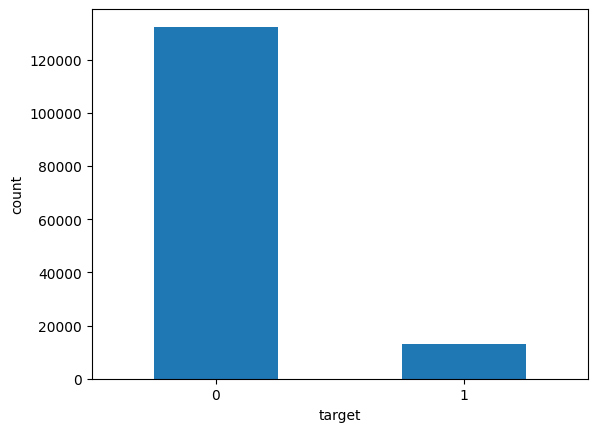

Fold 0:
--> fold train size: (84857, 331)
--> fold valid size: (8640, 331)
--> fold test size: (8640, 331)
  dataset  K  f1_score  precision  recall    TP    FP     TN   FN  \
0   train  0      0.82       0.71    0.95  7900  3166  73371  420   
1   valid  0      0.19       0.19    0.19   115   489   7538  498   
2    test  0      0.19       0.23    0.17    94   318   7757  471   

             Min_date            Max_date train_duration  profit_percent  \
0 2023-01-10 03:55:00 2024-02-26 19:15:00           41.4             NaN   
1 2024-04-08 19:20:00 2024-05-20 19:15:00           41.4           280.0   
2 2024-05-20 19:20:00 2024-07-01 19:15:00           41.4            50.1   

   max_dd n_unique_days n_max_daily_sig  
0     NaN          None            None  
1  -67.48            22              90  
2  -23.70            22              68  
Fold 1:
--> fold train size: (102137, 331)
--> fold valid size: (8640, 331)
--> fold test size: (8640, 331)
  dataset  K  f1_score  precision  

In [48]:
if MANUAL_EXP:
    exp_obj, exp_metadata, artifact_name = main(
        manual = True,
        man_params = man_params[model_type],
        dataset_path = "/content/ML-Algotrading-Project/dataset/data/dataset/dataset.parquet",
        C5M_data_path = "/content/ML-Algotrading-Project/dataset/data/stage_one_data/",
    )

In [ ]:
imp_fe = list(exp_obj.feature_importance[exp_obj.feature_importance.cv<.5].feature_name)
exp_obj.feature_importance[exp_obj.feature_importance.cv<.5].feature_name

,feature_name
84,fe_market_close_EURUSD_Sydney_time
13,fe_time_hour
86,fe_market_close_EURUSD_London_time
51,fe_cndl_shift_EURUSD_M1440_HIGH_to_CLOSE_-1
175,fe_RSTD_EURUSD_M240_CLOSE_W14_cndl_M240
...,...
87,fe_cndl_EURUSD_M5_CLOSE_to_OPEN
21,fe_cndl_shift_EURUSD_M5_HIGH_to_CLOSE_-1
98,fe_cndl_EURUSD_M15_CLOSE_to_LOW
24,fe_cndl_shift_EURUSD_M5_CLOSE_to_LOW_-1


In [ ]:
def plot_feature_importances_scatter(importance_df, top_n=10, figsize=(8, 6)):
    # Calculate mean importance and sort features
    mean_importance = importance_df['mean_importance']
    sorted_idx = mean_importance.argsort()[::-1]
    top_features = importance_df.iloc[sorted_idx[:top_n]]
    imp_cols = [f for f in importance_df if 'importance_fold' in f]
    # Prepare data for scatter plot
    feature_names = top_features['feature_name']
    importance_values = top_features[imp_cols].values.T  # Transpose for plotting

    # Calculate median importance
    median_importance = top_features['median_importance']

    # Create scatter plot
    fig, ax = plt.subplots(figsize=figsize)

    for i, feature in enumerate(feature_names):
        ax.scatter([i] * importance_values.shape[0], importance_values[:, i],
                   alpha=0.6, label=feature)

    # Plot median line
    ax.plot(range(top_n), median_importance, color='red', linestyle='--',
            linewidth=2, label='Median')

    # Add value labels on the median line
    for i, v in enumerate(median_importance):
        ax.text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=12)
    ax.set_title(f'Top {top_n} Feature Importances Across Folds with Median', fontsize=14)
    ax.set_xticks(range(top_n))
    ax.set_xticklabels(feature_names, rotation=45, ha='right')
#     ax.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

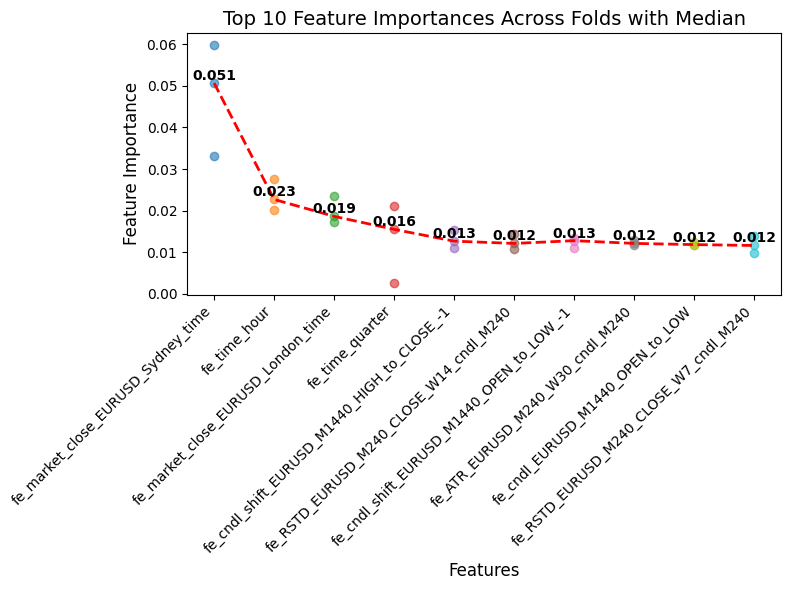

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plot_feature_importances_scatter(exp_obj.feature_importance)

### Save manual object on W&B as Artifact

In [ ]:
if MANUAL_EXP:
    wandb.init(entity = 'alpha-hunters', project = 'algotrading-project')
    obj_artifact = wandb.Artifact(artifact_name, 'manual_experiment', metadata = exp_metadata)
    obj_artifact.add_file(local_path=exp_obj.store_name+'.zip', name=exp_obj.store_name+'.zip')
    wandb.log_artifact(obj_artifact)

In [ ]:
if MANUAL_EXP:
    wandb.finish()

## Save imp_features (when we have RANDOM features)

In [ ]:
if MANUAL_EXP:
    upload_imp_features = True
    symbol = man_params[model_type]['target_symbol']
    trade_mode = man_params[model_type]['trade_mode']
    look_ahead = man_params[model_type]['look_ahead']
    take_profit = man_params[model_type]['take_profit']
    stop_loss = man_params[model_type]['stop_loss']

KeyError: 'look_ahead'

In [ ]:
if MANUAL_EXP and upload_imp_features :
    print('save_imp_features ')
    import pickle as pkl
    the_name = f"df_feature_imp_{trade_mode}_{symbol}_M{look_ahead}_TP{take_profit}_SL{stop_loss}.pkl"
    file = open(the_name, 'wb')
    pkl.dump(exp_obj.feature_importance,file)
    file.close()

    imp_artifact_name = artifact_name + '_imp_features'
    wandb.init(entity = 'alpha-hunters', project = 'algotrading-project', job_type="feature_selection")
    imp_artifact = wandb.Artifact(imp_artifact_name, 'feature_selection', metadata = exp_metadata)
    imp_artifact.add_file(local_path = the_name,name = the_name)
    print(f"--> dataset size MB: {imp_artifact.size / 1000000}")
    wandb.log_artifact(imp_artifact)
    wandb.finish()

# 2. Sweep Experiment using W&B

In [ ]:
sweep_configs = {}
sweep_configs['RF'] = {
    "method": "grid",
#     "metric": {"name": "class 1 f0.03_score_train", "goal": "maximize"},
#     'description':description,
    "parameters": {
        'model_name' : {"values": ['RF']},

        'target_symbol' : {"values": ['EURUSD']},
        'trade_mode' : {"values": ['long']},
        "trg_look_ahead": {"values": [120]},
        "trg_take_profit": {"values": [12]},
        "trg_stop_loss": {"values": [5]},

        "strg_look_ahead": {"values": [120]},
        "strg_take_profit": {"values": [12]},
        "strg_stop_loss": {"values": [5]},

        'save_model_mode' : {"values": ['last_train_size']}, # None, 'sample_train_size', 'last_train_size', 'all_data',
        'imp_features' : {"values": [None]},  #  can be set to imp_features or None
        'n_rand_features': {"values": [None]},
        "early_stopping_rounds" :{"values": [None]},
        "n_splits" : {"values": [17]},
        "max_train_size": {"values": [500*288]},
        'test_size' : {"values": [30*288]},
        'train_test_gap' : {"values": [0]},


        'n_estimators' : {"values": [200]},
        'max_depth': {"values": [5,12]},
        'max_features' : {"values": [30, 50,80]},
        'max_samples' : {"values": [0.2,0.3,0.4]},
        'class_weight':{'values':[0.13,0.15, 0.18, 0.23]},
        'n_jobs': {"values": [-1]},
        'random_state' : {"values": [42]},

#         "objective": {"values": ["binary:logistic"]},

#         "max_depth": {"values": [2, 5, 8, 15, 20, 30]},
#         "learning_rate": {"distribution": "uniform", "min": 0.005, "max": 0.01},
#         "n_estimators": {"distribution": "int_uniform", "min": 50, "max": 300},
#         "min_child_weight": {"distribution": "uniform", "min": 0, "max": 1}, # Used to control over-fitting.
#         "subsample": {"distribution": "uniform", "min": 0.3, "max": 0.5 } ,#Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.


#         "early_stopping_rounds" :{"distribution": "int_uniform", "min": 5, "max": 150},
#         "early_stopping_rounds" :{"values": [40,200]},
#         "gamma": {"distribution": "uniform", "min": 0, "max": 15}, #? float
#         "max_delta_step": {"distribution": "uniform", "min": 0, "max": 15}, #?float
#         "colsample_bytree": {"distribution": "uniform", "min": 0.5, "max": 0.75},
#         "reg_lambda": {"distribution": "uniform", "min": 0, "max": 10},
#         "reg_alpha": {"distribution": "uniform", "min": 0, "max": 10},
#         "train_data_precent": {"distribution": "uniform", "min": 0, "max": 0.98},
#         "train_data_precent": {"distribution": "uniform", "min": 0.5, "max": 0.95},
    },
}

In [ ]:
sweep_configs['XGB'] = {
    "method": "grid",

    "parameters": {
        'model_name' : {"values": ['XGB']},

        'target_symbol' : {"values": ['EURUSD']}, # ["EURUSD","USDCAD","USDJPY","EURJPY","GBPUSD","XAUUSD"]
        'trade_mode' : {"values": ['long']}, # "long", "short"
        "trg_look_ahead": {"values": [300]},
        "trg_take_profit": {"values": [35]},
        "trg_stop_loss": {"values": [5]},

        "strg_look_ahead": {"values": [480]},
        "strg_take_profit": {"values": [40]},
        "strg_stop_loss": {"values": [15]},

        'n_rand_features': {"values": [None]}, # None or Number
        'save_model_mode' : {"values": [None]}, # None, 'sample_train_size', 'last_train_size', 'all_data',

        "early_stopping_rounds" :{"values": [None]}, #None or Number
        'n_splits' : {"values":[3]},
        'max_train_size' : {"values":[400*288,300*288]},
        'test_size' : {"values":[30*288]},
        'train_test_gap' : {"values": [0]},

        "objective": {"values": ["binary:logistic"]},
        "max_depth": {"values": [4,5]},
        "learning_rate": {"values": [0.1,0.01,0.05]},
        'tree_method': {"values": [None]}, #'hist', None
        'device' : {"values": ["cpu"]}, # 'cuda', None
#         "learning_rate": {"distribution": "log_uniform", "min": 1e-5, "max": 5e-1},
        "n_estimators": {"values": [100]},
#         "early_stopping_rounds" :{"distribution": "int_uniform", "min": 5, "max": 150},
#         "early_stopping_rounds" :{"values": [40,200]},
#         "gamma": {"distribution": "uniform", "min": 0, "max": 15}, #? float
        "min_child_weight": {"values": [1]}, # Used to control over-fitting.
#         "max_delta_step": {"distribution": "uniform", "min": 0, "max": 15}, #?float
        "subsample": {"values": [0.3,0.5,0.8]},#Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
        "colsample_bytree": {"values": [0.5,0.8]},
        "reg_lambda": {"values": [0,0.02,0.1]},
#         "reg_alpha": {"distribution": "uniform", "min": 0, "max": 10},
        "scale_pos_weight" : {"values": [1]},#[1,0.95,1.1]
        'random_state': {"values":[42]},
        },
}

In [ ]:
%%time

sweep_id = wandb.sweep(
    sweep_configs[model_type],
    entity = 'alpha-hunters',
    project = 'algotrading-project'
)

#!!!!!!!!!!!! SWEEP ID !!!!!!!!!!!!!!!!!
wandb.agent(sweep_id = sweep_id, function = main, entity = 'alpha-hunters',project = 'algotrading-project')
wandb.finish()

Create sweep with ID: g53srmr3
Sweep URL: https://wandb.ai/alpha-hunters/algotrading-project/sweeps/g53srmr3


wandb: Agent Starting Run: wr0zksoc with config:
wandb: 	colsample_bytree: 0.5
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	max_train_size: 115200
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.3
wandb: 	target_symbol: EURUSD
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.5, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.3, 'tree_method': None}
Dataset file not found at: /kaggle/input/algotrading-project/dataset.parquet
[Errno 2] Failed to open local file '/content/ML-Algotrading-Project/dataset/data/dataset/dataset.parquet'. Detail: [errno 2] No such file or directory


Traceback (most recent call last):
  File "/content/ML-Algotrading-Project/main_func.py", line 121, in main
    df_all = ETL(
  File "/content/ML-Algotrading-Project/ETL.py", line 45, in ETL
    raw_columns = [f.name for f in ParquetFile(path).schema]
  File "/usr/local/lib/python3.10/dist-packages/pyarrow/parquet/core.py", line 313, in __init__
    source = filesystem.open_input_file(source)
  File "pyarrow/_fs.pyx", line 783, in pyarrow._fs.FileSystem.open_input_file
  File "pyarrow/error.pxi", line 154, in pyarrow.lib.pyarrow_internal_check_status
  File "pyarrow/error.pxi", line 91, in pyarrow.lib.check_status
FileNotFoundError: [Errno 2] Failed to open local file '/content/ML-Algotrading-Project/dataset/data/dataset/dataset.parquet'. Detail: [errno 2] No such file or directory


Run wr0zksoc errored:
Traceback (most recent call last):
  File "/content/ML-Algotrading-Project/main_func.py", line 121, in main
    df_all = ETL(
  File "/content/ML-Algotrading-Project/ETL.py", line 45, in ETL
    raw_columns = [f.name for f in ParquetFile(path).schema]
  File "/usr/local/lib/python3.10/dist-packages/pyarrow/parquet/core.py", line 313, in __init__
    source = filesystem.open_input_file(source)
  File "pyarrow/_fs.pyx", line 783, in pyarrow._fs.FileSystem.open_input_file
  File "pyarrow/error.pxi", line 154, in pyarrow.lib.pyarrow_internal_check_status
  File "pyarrow/error.pxi", line 91, in pyarrow.lib.check_status
FileNotFoundError: [Errno 2] Failed to open local file '/content/ML-Algotrading-Project/dataset/data/dataset/dataset.parquet'. Detail: [errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 3

Final Parameters of the Model: {'colsample_bytree': 0.5, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': None}
Dataset file not found at: /kaggle/input/algotrading-project/dataset.parquet
[Errno 2] Failed to open local file '/content/ML-Algotrading-Project/dataset/data/dataset/dataset.parquet'. Detail: [errno 2] No such file or directory


Traceback (most recent call last):
  File "/content/ML-Algotrading-Project/main_func.py", line 121, in main
    df_all = ETL(
  File "/content/ML-Algotrading-Project/ETL.py", line 45, in ETL
    raw_columns = [f.name for f in ParquetFile(path).schema]
  File "/usr/local/lib/python3.10/dist-packages/pyarrow/parquet/core.py", line 313, in __init__
    source = filesystem.open_input_file(source)
  File "pyarrow/_fs.pyx", line 783, in pyarrow._fs.FileSystem.open_input_file
  File "pyarrow/error.pxi", line 154, in pyarrow.lib.pyarrow_internal_check_status
  File "pyarrow/error.pxi", line 91, in pyarrow.lib.check_status
FileNotFoundError: [Errno 2] Failed to open local file '/content/ML-Algotrading-Project/dataset/data/dataset/dataset.parquet'. Detail: [errno 2] No such file or directory


Run zqa88jcs errored:
Traceback (most recent call last):
  File "/content/ML-Algotrading-Project/main_func.py", line 121, in main
    df_all = ETL(
  File "/content/ML-Algotrading-Project/ETL.py", line 45, in ETL
    raw_columns = [f.name for f in ParquetFile(path).schema]
  File "/usr/local/lib/python3.10/dist-packages/pyarrow/parquet/core.py", line 313, in __init__
    source = filesystem.open_input_file(source)
  File "pyarrow/_fs.pyx", line 783, in pyarrow._fs.FileSystem.open_input_file
  File "pyarrow/error.pxi", line 154, in pyarrow.lib.pyarrow_internal_check_status
  File "pyarrow/error.pxi", line 91, in pyarrow.lib.check_status
FileNotFoundError: [Errno 2] Failed to open local file '/content/ML-Algotrading-Project/dataset/data/dataset/dataset.parquet'. Detail: [errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 3

Final Parameters of the Model: {'colsample_bytree': 0.5, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': None}
Dataset file not found at: /kaggle/input/algotrading-project/dataset.parquet
[Errno 2] Failed to open local file '/content/ML-Algotrading-Project/dataset/data/dataset/dataset.parquet'. Detail: [errno 2] No such file or directory


Traceback (most recent call last):
  File "/content/ML-Algotrading-Project/main_func.py", line 121, in main
    df_all = ETL(
  File "/content/ML-Algotrading-Project/ETL.py", line 45, in ETL
    raw_columns = [f.name for f in ParquetFile(path).schema]
  File "/usr/local/lib/python3.10/dist-packages/pyarrow/parquet/core.py", line 313, in __init__
    source = filesystem.open_input_file(source)
  File "pyarrow/_fs.pyx", line 783, in pyarrow._fs.FileSystem.open_input_file
  File "pyarrow/error.pxi", line 154, in pyarrow.lib.pyarrow_internal_check_status
  File "pyarrow/error.pxi", line 91, in pyarrow.lib.check_status
FileNotFoundError: [Errno 2] Failed to open local file '/content/ML-Algotrading-Project/dataset/data/dataset/dataset.parquet'. Detail: [errno 2] No such file or directory


Run u78ndt7w errored:
Traceback (most recent call last):
  File "/content/ML-Algotrading-Project/main_func.py", line 121, in main
    df_all = ETL(
  File "/content/ML-Algotrading-Project/ETL.py", line 45, in ETL
    raw_columns = [f.name for f in ParquetFile(path).schema]
  File "/usr/local/lib/python3.10/dist-packages/pyarrow/parquet/core.py", line 313, in __init__
    source = filesystem.open_input_file(source)
  File "pyarrow/_fs.pyx", line 783, in pyarrow._fs.FileSystem.open_input_file
  File "pyarrow/error.pxi", line 154, in pyarrow.lib.pyarrow_internal_check_status
  File "pyarrow/error.pxi", line 91, in pyarrow.lib.check_status
FileNotFoundError: [Errno 2] Failed to open local file '/content/ML-Algotrading-Project/dataset/data/dataset/dataset.parquet'. Detail: [errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 3

CPU times: user 3.08 s, sys: 220 ms, total: 3.3 s
Wall time: 44.6 s


In [ ]:
# Import necessary libraries
import wandb

# The sweep ID should be the same as the one you started with
sweep_id = 'wviokop8'

# Resume the sweep
wandb.agent(sweep_id=sweep_id, function=main, entity='alpha-hunters', project='algotrading-project')

# Finish the sweep
wandb.finish()

wandb: Agent Starting Run: tbbp7xqa with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	max_train_size: 86400
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.3
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.3, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 3.00 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall  TP  FP     TN    FN  \
0   train  0      0.02        1.0    0.01  65   0  72267  5897   
1   valid  0      0.00        0.0    0.00   0   0   8290   350   
2    test  0      0.00        0.0    0.00   0 

/kaggle/working/ML-Algotrading-Project/utils/evaluation_utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  f"precision_total_{set_name}": evals_df.TP.sum() / (evals_df.TP.sum() + evals_df.FP.sum()),
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_20:52.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_20:52.pkl


f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁
max_dd_min_valid,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bnqimesv with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	max_train_size: 86400
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.5
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.95 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall  TP  FP     TN    FN  \
0   train  0      0.02       0.97    0.01  67   2  72265  5895   
1   valid  0      0.00       0.00    0.00   0   0   8290   350   
2    test  0      0.00       0.00    0.00   0 

/kaggle/working/ML-Algotrading-Project/utils/evaluation_utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  f"precision_total_{set_name}": evals_df.TP.sum() / (evals_df.TP.sum() + evals_df.FP.sum()),
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_20:54.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_20:54.pkl


f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁
max_dd_min_valid,▁


wandb: Agent Starting Run: n4m09q6k with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	max_train_size: 86400
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.8
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.94 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall  TP  FP     TN    FN  \
0   train  0      0.03        1.0    0.01  83   0  72267  5879   
1   valid  0      0.00        0.0    0.00   0   0   8290   350   
2    test  0      0.00        0.0    0.00   0 

/kaggle/working/ML-Algotrading-Project/utils/evaluation_utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  f"precision_total_{set_name}": evals_df.TP.sum() / (evals_df.TP.sum() + evals_df.FP.sum()),
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_20:56.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_20:56.pkl


f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁
max_dd_min_valid,▁


wandb: Agent Starting Run: oo24xsnq with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	max_train_size: 86400
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0.02
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.3
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0.02, 'scale_pos_weight': 1, 'subsample': 0.3, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.92 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall  TP  FP     TN    FN  \
0   train  0      0.02        1.0    0.01  47   0  72267  5915   
1   valid  0      0.00        0.0    0.00   0   5   8285   350   
2    test  0      0.00        0.0    0.00  

/kaggle/working/ML-Algotrading-Project/utils/evaluation_utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  f"precision_total_{set_name}": evals_df.TP.sum() / (evals_df.TP.sum() + evals_df.FP.sum()),
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_20:57.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_20:57.pkl


f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁
max_dd_min_valid,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m8xrq7b9 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	max_train_size: 86400
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0.02
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.5
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0.02, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.98 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
  dataset  K  f1_score  precision  recall  TP  FP     TN    FN  \
0   train  0      0.03        1.0    0.01  88   0  72267  5874   
1   valid  0      0.00        0.0    0.00   0   2   8288   350   
2    test  0      0.00        0.0    0.00   0   0   8210   430   

             Min_date            Max_date train_duration  profit_percent  \
0 2023-

/kaggle/working/ML-Algotrading-Project/utils/evaluation_utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  f"precision_total_{set_name}": evals_df.TP.sum() / (evals_df.TP.sum() + evals_df.FP.sum()),
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:01.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:01.pkl


f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁
max_dd_min_valid,▁


wandb: Agent Starting Run: ahtdc0pq with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	max_train_size: 86400
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0.1
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.3
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'subsample': 0.3, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.92 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall  TP  FP     TN    FN  \
0   train  0      0.01        1.0    0.01  40   0  72267  5922   
1   valid  0      0.00        0.0    0.00   0   0   8290   350   
2    test  0      0.00        0.0    0.00   

/kaggle/working/ML-Algotrading-Project/utils/evaluation_utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  f"precision_total_{set_name}": evals_df.TP.sum() / (evals_df.TP.sum() + evals_df.FP.sum()),
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:03.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:03.pkl


f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁
max_dd_min_valid,▁


wandb: Agent Starting Run: cj63npli with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	max_train_size: 86400
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0.1
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.5
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.95 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall  TP  FP     TN    FN  \
0   train  0      0.02       0.97    0.01  56   2  72265  5906   
1   valid  0      0.00       0.00    0.00   0   3   8287   350   
2    test  0      0.00       0.00    0.00   

/kaggle/working/ML-Algotrading-Project/utils/evaluation_utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  f"precision_total_{set_name}": evals_df.TP.sum() / (evals_df.TP.sum() + evals_df.FP.sum()),
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:05.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:05.pkl


f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁
max_dd_min_valid,▁


wandb: Agent Starting Run: qeetxusn with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	max_train_size: 86400
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0.1
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.8
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.91 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall  TP  FP     TN    FN  \
0   train  0      0.03       0.99    0.01  80   1  72266  5882   
1   valid  0      0.00       0.00    0.00   0   0   8290   350   
2    test  0      0.00       0.00    0.00   

/kaggle/working/ML-Algotrading-Project/utils/evaluation_utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  f"precision_total_{set_name}": evals_df.TP.sum() / (evals_df.TP.sum() + evals_df.FP.sum()),
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:07.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:07.pkl


f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁
max_dd_min_valid,▁


wandb: Agent Starting Run: l6suh3m6 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	max_train_size: 115200
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.3
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.3, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.94 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall   TP  FP     TN    FN  \
0   train  0      0.08       0.98    0.04  252   4  72263  5710   
1   valid  0      0.00       0.00    0.00    0   0   8290   350   
2    test  0      0.00       0.00    0.00  

/kaggle/working/ML-Algotrading-Project/utils/evaluation_utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  f"precision_total_{set_name}": evals_df.TP.sum() / (evals_df.TP.sum() + evals_df.FP.sum()),
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:09.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:09.pkl


f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁
max_dd_min_valid,▁


wandb: Agent Starting Run: jw6jkpjn with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	max_train_size: 115200
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.5
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.95 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall   TP  FP     TN    FN  \
3   train  1       0.1       0.97    0.05  362  10  88757  6380   
4   valid  1       0.0       0.33    0.00    1   2   8157   480   
5    test  1       0.0       0.00    0.00  

/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof64.20_max_dd-3.84_median_sig2.00_date2024-10-17_21:11.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof64.20_max_dd-3.84_median_sig2.00_date2024-10-17_21:11.pkl


f1_score_ex0_test,▁
f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁


wandb: Agent Starting Run: sti2255y with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	max_train_size: 115200
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.8
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.90 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall   TP  FP     TN    FN  \
0   train  0      0.09       0.99    0.05  288   3  72264  5674   
1   valid  0      0.00       0.00    0.00    0   0   8290   350   
2    test  0      0.00       0.00    0.00  

/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof20.10_max_dd-4.89_median_sig0.00_date2024-10-17_21:13.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof20.10_max_dd-4.89_median_sig0.00_date2024-10-17_21:13.pkl


f1_score_ex0_test,▁
f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁


wandb: Agent Starting Run: a1lazy0h with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	max_train_size: 115200
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0.02
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.3
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0.02, 'scale_pos_weight': 1, 'subsample': 0.3, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.87 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall   TP  FP     TN    FN  \
0   train  0      0.07       0.99    0.04  225   2  72265  5737   
1   valid  0      0.00       0.00    0.00    0   8   8282   350   
2    test  0      0.00       0.00    0.0

/kaggle/working/ML-Algotrading-Project/utils/evaluation_utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  f"precision_total_{set_name}": evals_df.TP.sum() / (evals_df.TP.sum() + evals_df.FP.sum()),
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:15.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:15.pkl


f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁
max_dd_min_valid,▁


wandb: Agent Starting Run: 51bzxp7a with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	max_train_size: 115200
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0.02
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.5
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0.02, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.89 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall   TP  FP     TN    FN  \
0   train  0      0.09       0.98    0.05  282   7  72260  5680   
1   valid  0      0.00       0.00    0.00    0   7   8283   350   
2    test  0      0.00       0.00    0.0

f1_score_ex0_test,▁
f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁


wandb: Agent Starting Run: yxnsadto with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	max_train_size: 115200
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0.02
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.8
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0.02, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.91 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall   TP  FP     TN    FN  \
0   train  0      0.08       0.98    0.04  243   5  72262  5719   
1   valid  0      0.00       0.00    0.00    0   0   8290   350   
2    test  0      0.00       0.00    0.0

/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof32.70_max_dd-4.62_median_sig0.00_date2024-10-17_21:20.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof32.70_max_dd-4.62_median_sig0.00_date2024-10-17_21:20.pkl


f1_score_ex0_test,▁
f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁


wandb: Agent Starting Run: oxz3ugzk with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	max_train_size: 115200
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0.1
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.3
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'subsample': 0.3, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 3.08 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall   TP  FP     TN    FN  \
0   train  0      0.08       0.98    0.04  247   5  72262  5715   
1   valid  0      0.00       0.00    0.00    0   4   8286   350   
2    test  0      0.00       0.00    0.00

/kaggle/working/ML-Algotrading-Project/utils/evaluation_utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  f"precision_total_{set_name}": evals_df.TP.sum() / (evals_df.TP.sum() + evals_df.FP.sum()),
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:22.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:22.pkl


f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁
max_dd_min_valid,▁


wandb: Agent Starting Run: viv1074f with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	max_train_size: 115200
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0.1
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.5
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.95 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall   TP  FP     TN    FN  \
0   train  0      0.09       0.98    0.05  277   6  72261  5685   
1   valid  0      0.00       0.00    0.00    0   0   8290   350   
2    test  0      0.00       0.00    0.00

/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof5.90_max_dd0.00_median_sig0.00_date2024-10-17_21:24.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof5.90_max_dd0.00_median_sig0.00_date2024-10-17_21:24.pkl


f1_score_ex0_test,▁
f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁


wandb: Agent Starting Run: vvs1cojy with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	max_train_size: 115200
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0.1
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.8
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.91 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall   TP  FP     TN    FN  \
0   train  0      0.09       0.99    0.05  280   2  72265  5682   
1   valid  0      0.00       0.00    0.00    0   0   8290   350   
2    test  0      0.00       0.00    0.00

/kaggle/working/ML-Algotrading-Project/utils/evaluation_utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  f"precision_total_{set_name}": evals_df.TP.sum() / (evals_df.TP.sum() + evals_df.FP.sum()),
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:26.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:26.pkl


f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁
max_dd_min_valid,▁


wandb: Agent Starting Run: 0wp3o2iw with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	max_train_size: 86400
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.3
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.3, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 3.09 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)
  dataset  K  f1_score  precision  recall   TP  FP     TN    FN  \
0   train  0      0.08       0.98    0.04  252   4  72263  5710   
1   valid  0      0.00       0.00    0.00    0   0   8290   350   
2    test  0      0.00       0.00    0.00  

/kaggle/working/ML-Algotrading-Project/utils/evaluation_utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  f"precision_total_{set_name}": evals_df.TP.sum() / (evals_df.TP.sum() + evals_df.FP.sum()),
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


object stored as pickle: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:28.pkl
object pickle stored zipped: XGB_long_USDJPY_M300_TP35_SL5_prof0.00_max_dd0.00_median_sig0.00_date2024-10-17_21:28.pkl


f1_score_ex0_train,▁
f1_score_ex0_valid,▁
f1_score_ex0_valid&test,▁
max_dd_mean_test,▁
max_dd_mean_valid,▁
max_dd_mean_valid&test,▁
max_dd_median_test,▁
max_dd_median_valid,▁
max_dd_median_valid&test,▁
max_dd_min_test,▁
max_dd_min_valid,▁


wandb: Agent Starting Run: 1pejuzvi with config:
wandb: 	colsample_bytree: 0.8
wandb: 	device: cpu
wandb: 	early_stopping_rounds: None
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	max_train_size: 86400
wandb: 	min_child_weight: 1
wandb: 	model_name: XGB
wandb: 	n_estimators: 100
wandb: 	n_rand_features: None
wandb: 	n_splits: 3
wandb: 	objective: binary:logistic
wandb: 	random_state: 42
wandb: 	reg_lambda: 0
wandb: 	save_model_mode: None
wandb: 	scale_pos_weight: 1
wandb: 	strg_look_ahead: 480
wandb: 	strg_stop_loss: 15
wandb: 	strg_take_profit: 40
wandb: 	subsample: 0.5
wandb: 	target_symbol: USDJPY
wandb: 	test_size: 8640
wandb: 	trade_mode: long
wandb: 	train_test_gap: 0
wandb: 	tree_method: None
wandb: 	trg_look_ahead: 300
wandb: 	trg_stop_loss: 5
wandb: 	trg_take_profit: 35


Final Parameters of the Model: {'colsample_bytree': 0.8, 'device': 'cpu', 'early_stopping_rounds': None, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': None}
Len all columns in dataframe is 498
Len read columns is 498
Calculating target --->
---> Target trg_clf_long_USDJPY_M300_TP35_SL5 has been generated in 2.91 seconds
df shape:  (130069, 499)
--> df final shape: (130069, 498)
--> df min_time: 2023-01-10 03:55:00 | df max_time: 2024-10-02 18:55:00
--> number of unique days: 130069
Fold 0:
--> fold train size: (78229, 503)
--> fold valid size: (8640, 503)
--> fold test size: (8640, 503)


In [ ]:
#STOP SWEEP
if not MANUAL_EXP:
    print('Finishing The SWEEP ...')
    print(f'{1/0}')

# Filter models from W&B

In [ ]:
runs_filter = {'path' : "fitechivo/tradeset_models",# /artifacts/experiment/trg_clf_long_EURUSD_M240_TP25_SL10
               "order": "+summary_metrics.profit_percent_test",
    'filters': {"$and": [
#                         {"state":'finished'},
                        {"createdAt":{ '$gte': '2024-06-01' }},
                        {"sweep":'jmw8zpy9'},

                        ########### GENERAL CONFIG #############
                        {"config.target_symbol":'USDJPY'},
                        {"config.trade_mode": 'long'},
#                         {"config.look_ahead": 480},
#                         {"config.strg_take_profit": 40},
#                         {"config.strg_stop_loss": 15},
                        {"config.model_name":'XGB'},
#                         ########### MODEL CONFIG #############
#                         {"config.max_depth": 3 },
#                         {"config.n_estimators": { "$gte": 100 } },
#                         {"config.learning_rate": { "$lt": 1 }},
#                         {"config.random_state": 42 },

                        ########### MODEL METRICS #############
                        {"summary_metrics.profit_percent_test" : { "$gte": 10}},
                        {"summary_metrics.profit_percent_val" : { "$gte": 10}},

                        {"summary_metrics.profit_percent_median_test" : { "$gte": 5}},
                        {"summary_metrics.profit_percent_median_valid" : { "$gte": 5}},

                        {"summary_metrics.max_dd_min_test" : { "$gte":-40}},
                        {"summary_metrics.max_dd_min_valid" : { "$gte":-40}},

                        {"summary_metrics.max_dd_test" : { "$gte":-40}},
                        {"summary_metrics.max_dd_val" : { "$gte":-40}},



                                ]
            }
}
runs=api.runs(**runs_filter)
print(len(runs))

In [ ]:
# wandb.finish()

In [ ]:
import shutil
import os
if os.path.isdir("/kaggle/working/artifacts"):
    shutil.rmtree("/kaggle/working/artifacts")
meta_datas=fetch_artifacts(runs_filter)

In [ ]:
objects = read_tracker_objects("/kaggle/working/artifacts")

In [ ]:
# objects['XGB_long_USDJPY_M300_TP35_SL5_prof531.41_max_dd-56.54_median_sig9.00_date2024-07-08_21:24']['obj'].evals

## Selected Models' Config

In [ ]:
import pandas as pd
for i,k in enumerate(objects):
    if i == 0:
        df_config = pd.DataFrame(objects[k]['obj'].config, index = [0])
#         display(df_config)
    else:
        df_config = pd.concat([df_config,pd.DataFrame(objects[k]['obj'].config, index = [0])])
# df_config[['colsample_bytree',
#        'learning_rate', 'trg_look_ahead', 'max_depth', 'max_train_size',
#        'min_child_weight', 'model_name', 'n_estimators', 'save_model_mode', 'scale_pos_weight',
#        'subsample', 'trg_take_profit', 'target_symbol', 'tree_method']]
df_config

## Feature Importance

In [ ]:
for i,k in enumerate(objects):
    if i == 0:
        df_imp = objects[k]['obj'].feature_importance
        df_imp.rename(columns = {'importances': f'importances_{i}'}, inplace =True)
    else:

        df_imp = df_imp.merge(objects[k]['obj'].feature_importance.rename(columns = {'importances': f'importances_{i}'}),
                             on = 'feature_name')
imp_cols = [f for f in df_imp.columns if 'importances_' in f]
df_imp['imp_mean'] =df_imp[imp_cols].mean(axis = 1)
df_imp.sort_values('imp_mean', ascending = False)[:30]

## Models' Correlation

In [ ]:
import pandas as pd
def cal_corr_tar1_predictions(objects):
    '''Calculate corrilation between models Just for target==1'''
    corr_ls=[]
    for i,n in enumerate(objects):

        val_predictions = objects[n]['obj'].val_predictions
        val_predictions=val_predictions[val_predictions.target==1][['pred_as_val','target']].replace(0, -1)
        corr_ls.append((n,val_predictions))
    print("Total_model_count:", len(corr_ls))

    from sklearn.metrics import matthews_corrcoef
    corr_dict={}
    for i in range(0,len(corr_ls)):
        for j in range(i+1,len(corr_ls)):
            corr_dict[(corr_ls[i][0],corr_ls[j][0])]=matthews_corrcoef(corr_ls[i][1]['pred_as_val'], corr_ls[j][1]['pred_as_val'])


    corr_df=pd.DataFrame([k + (v,) for k, v in corr_dict.items()], columns=['model1', 'model2', 'M_corr'])
    print('combination checked:', corr_df.shape[0])
    corr_df.hist('M_corr')
    return corr_df

corr_df=cal_corr_tar1_predictions(objects)

In [ ]:
# corr_df[corr_df.M_corr<0.7]
corr_df